# This is a place to test post-processing blocks. Not to run fem solver multiple times

In [1]:
import blocks as bl
import elementDefs as ed
import constants as cst
import copy
import numpy.typing as nt
import typing as ty
import numpy as np
import scipy.sparse as ss
import scipy.sparse.linalg as ssl
import scipy.optimize as opt
import loads as ls
import typing as ty
import functools as ftl
import geometricClasses as gcl

In [2]:
import pyfe3d as pf3
import pyfe3d.shellprop_utils as psp
import pyfe3Dgcl as p3g

In [3]:
'''Standard test setup'''
data = cst.CAD_DATA
lgl_infs = [4, 4.5, 5, 6] #preparing the k infinity values
csts = copy.deepcopy(cst.CONSTS) #not to touch the actual constants dict
load_case = cst.LOAD_C[2]#landing load case used in the sensitivity study
#load_case["FT"] = 5000 #landing at full thrust - a weird load case that tests everything at once
eleDict = ed.eledict(csts, cst.INITIAL, cst.CODES)
meshOut = bl.mesh_block(data, cst.INITIAL, eleDict, csts, cst.CODES)

In [4]:
'''Solution cell - run at your own risk XD'''
sol = bl.fem_linear_block(csts, meshOut, load_case, True, True)

2873468.7352413973 2838829.0200302824  error: -0.012055017264074985


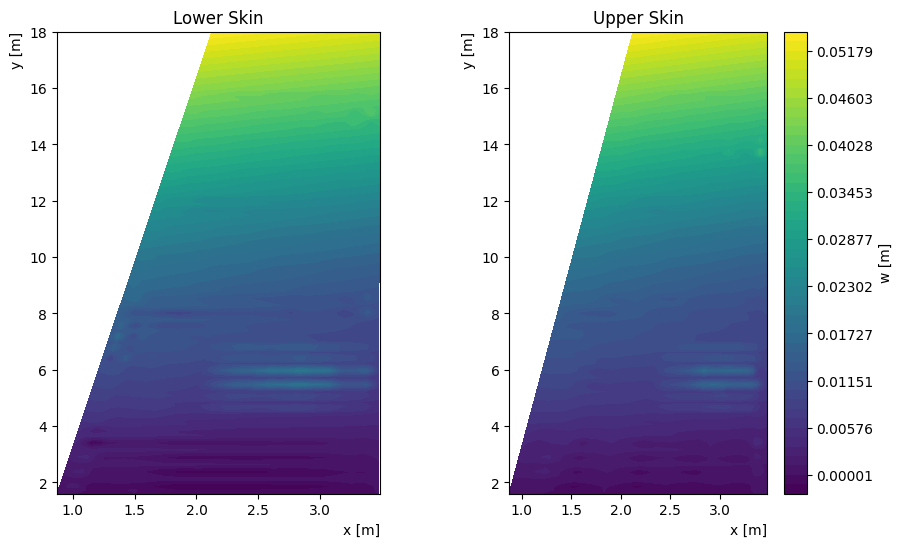

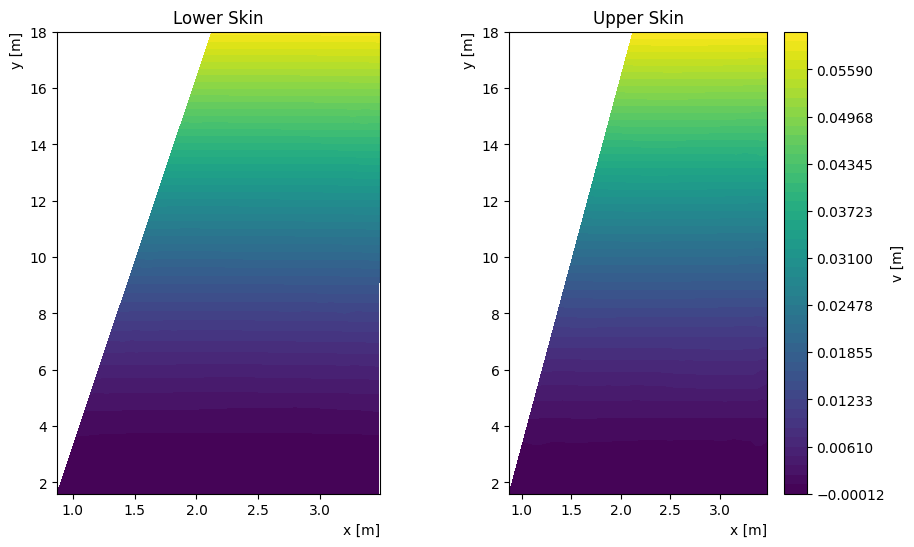

In [5]:
'''Standard deflection plots to check the solution's quality'''
wfig = bl.plot_block(sol['w'], "w", meshOut, csts)
vfig = bl.plot_block(sol['v'], "v", meshOut, csts)

## Ill-conditioning, son

292628.5584235291
-29317.92607874355
-1079014.0047673052


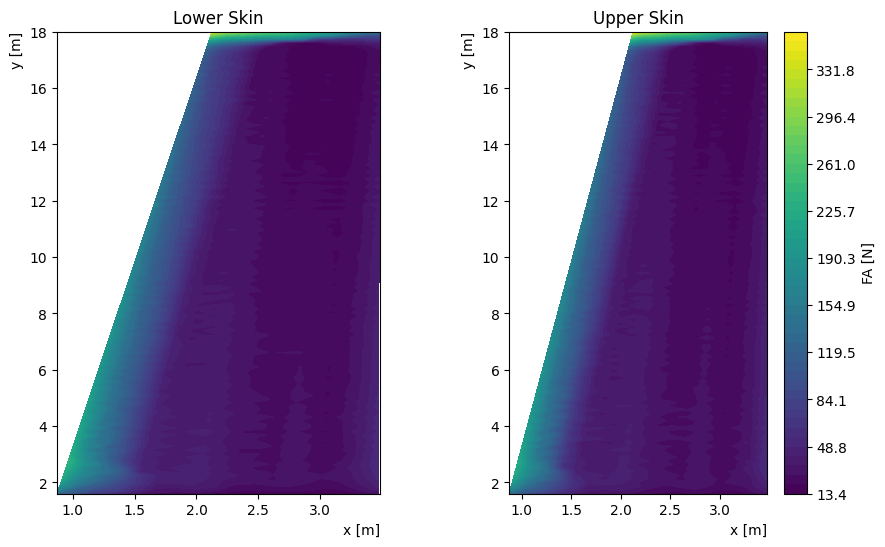

In [6]:
bl.plot_block(sol["Fext"][2::pf3.DOF], "FA", meshOut, cst.CONSTS, "N")
print(sol["Fext"][2::pf3.DOF].sum())
print(sol["Fext"][1::pf3.DOF].sum())
print(sol["weight"].sum())

In [7]:
import pyvista as pv
#nodes is our ncoords
elements = meshOut["elements"]
nid_pos = meshOut["nid_pos"]

'''handling each element separately at each elemnt type gets a diff colour'''
#quads
edges_q = list()
for s in elements["quad"]:
    edges_q.append([nid_pos[s.n1], nid_pos[s.n2]])
    edges_q.append([nid_pos[s.n2], nid_pos[s.n3]])
    edges_q.append([nid_pos[s.n3], nid_pos[s.n4]])
    edges_q.append([nid_pos[s.n4], nid_pos[s.n1]])
colors_q = [3]*len(edges_q)

#beams
edges_b = list()
for s in elements["beam"]:
    edges_b.append([nid_pos[s.n1], nid_pos[s.n2]])
colors_b = [2]*len(edges_b)


edges = np.array(edges_b+edges_q)
colors = np.array(colors_b+colors_q)

# We must "pad" the edges to indicate to vtk how many points per edge
padding = np.empty(edges.shape[0], int) * 2
padding[:] = 2
edges_w_padding = np.vstack((padding, edges.T)).T

displs = np.vstack([sol["u"][0::pf3.DOF]+sol["u"][1::pf3.DOF]+sol["u"][2::pf3.DOF]]).T
mesh_ = pv.PolyData(meshOut["ncoords"]+displs, edges_w_padding)

mesh_.plot(
    scalars=colors,
    render_lines_as_tubes=True,
    style='wireframe',
    line_width=1,
    cmap='jet',
    show_scalar_bar=False,
    background='w',
)

Widget(value='<iframe src="http://localhost:64327/index.html?ui=P_0x1ec1d3e1a60_0&reconnect=auto" class="pyvis…

KeyboardInterrupt: 

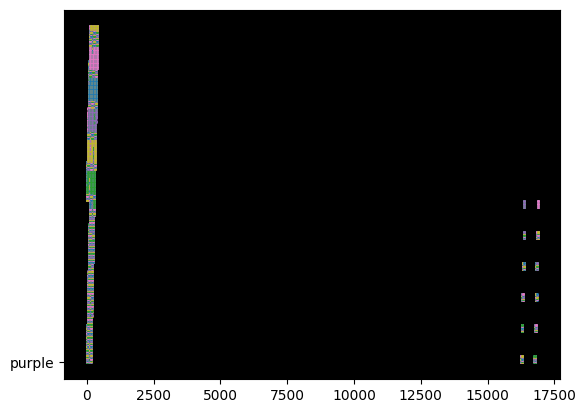

In [ ]:
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix

def colour_scale(val:float):
    log = np.log10(val) if val>0 else 0
    if log < 2:
        color = 'purple'
    elif log < 4:
        color = 'blue'
    elif log <6:
        color = 'cyan'
    elif log <8:
        color = 'yellow'
    elif log <10:
        color = 'orange'
    else:
        color = 'red'
    return color

def plot_coo_matrix(m):
    if not isinstance(m, coo_matrix):
        m = coo_matrix(m)
    mcsr = m.tocsr()
    fig = plt.figure()
    ax = fig.add_subplot(111, facecolor='black')
    for row, col in zip(m.row, m.col):
        ax.plot(row, col, 's', colour_scale(mcsr[row, col]), ms=1)
    ax.set_xlim(0, m.shape[1])
    ax.set_ylim(0, m.shape[0])
    ax.set_aspect('equal')
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.invert_yaxis()
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    return ax

plot_coo_matrix(meshOut["M"])

In [ ]:
'''CONDITION NUMBER CHECK'''
def condition_check(A):
    ew1, ev1 = ssl.eigs(A, which='LM')
    print(f"lagest eig:{ew1}")
    print("SM starts")
    ew2, ev2 = ssl.eigs(A, sigma=1e9, which="LM")   #<--- takes a long time
    print(f"smallest eig:{ew1}")

    ew1 = abs(ew1)
    ew2 = abs(ew2)

    condA = ew1.max()/ew2.min()

    #PLOTTING EIGEN VECTORS
    # bl.plot_block(ev1[0::pf3.DOF, 0], "evBIGx1", meshOut, cst.CONSTS)
    # bl.plot_block(ev1[2::pf3.DOF, 1], "evBIGx2", meshOut, cst.CONSTS)
    # bl.plot_block(ev2[0::pf3.DOF, 0], "evSMALLx1", meshOut, cst.CONSTS)
    # bl.plot_block(ev2[2::pf3.DOF, 1], "evSMALLx2", meshOut, cst.CONSTS)

    return condA

print(f"condition num of Kuu-KAuu: {condition_check(sol["KC0uu"]-sol["KAuu"])}")
print(f"condition num of M: {condition_check(meshOut["M"])}")

lagest eig:[5.84434912e+13+0.j 5.84492149e+13+0.j 1.52256600e+13+0.j
 1.52272113e+13+0.j 9.60516575e+12+0.j 9.60579800e+12+0.j]
SM starts
smallest eig:[5.84434912e+13+0.j 5.84492149e+13+0.j 1.52256600e+13+0.j
 1.52272113e+13+0.j 9.60516575e+12+0.j 9.60579800e+12+0.j]
condition num of Kuu-KAuu: 58465.541651557956
lagest eig:[2877.40787901+0.j 2877.14886017+0.j  756.78687031+0.j  756.68254915+0.j
  470.69156524+0.j  470.67475517+0.j]
SM starts
smallest eig:[2877.40787901+0.j 2877.14886017+0.j  756.78687031+0.j  756.68254915+0.j
  470.69156524+0.j  470.67475517+0.j]
condition num of M: 6.113367762933242


# Post processor - attempt 2

In [6]:
def update_after_displacement(meshOut:ty.Dict[str, object], sol:ty.Dict[str, object]):
    "Returns the KG matrix and internal force vector after the displacements from the solver are applied"
    KC0, M, N, x, y, z, mesh, up, ids, pts, nid_pos, ncoords = tuple(meshOut[k] for k in ['KC0', 'M', 'N', 'x', 'y', 'z', 'mesh', 'up', 'ids', 'pts', 'nid_pos', 'ncoords'])
    eleDict, KGv, KGr, KGc, ncoords_flatten = tuple(meshOut[k] for k in ['elements', 'KGv', 'KGr', 'KGc', 'ncoords_flatten'])
    fi = np.zeros(meshOut["N"])
    u, bu, bk, Kuu = tuple(sol[k] for k in ["u", "bu", "bk", "KC0uu"])


    for quad in eleDict["quad"]:
        # NOTE update affects the Quad4RProbe class attribute ue
        quad.update_probe_ue(u)
        quad.update_probe_xe(ncoords_flatten)
        quad.update_KG(KGr, KGc, KGv, quad.shellprop)
        quad.update_probe_finte(quad.shellprop)
        quad.update_fint(fi, quad.shellprop)
    
    for beam in eleDict["beam"]:
        beam.update_probe_ue(u)
        beam.update_probe_xe(ncoords_flatten)
        beam.update_KG(KGr, KGc, KGv, beam.beamprop, 0) #here only values change
        beam.update_probe_finte(beam.beamprop)
        beam.update_fint(fi, beam.beamprop)

    KG = ss.coo_matrix((KGv, (KGr, KGc)), shape=(N, N)).tocsc()
    KGuu = KG[bu, :][:, bu]

    return fi, KGuu, KG
    


In [7]:
fi, KGuu, KG = update_after_displacement(meshOut, sol)
#NOTE: te very high values in fi are the reaction forces
# bl.plot_block(fi[0::pf3.DOF], "Fi_x", meshOut, cst.CONSTS, "N")
# bl.plot_block(fi[1::pf3.DOF], "Fi_y", meshOut, cst.CONSTS, "N")
# bl.plot_block(fi[2::pf3.DOF], "Fi_z", meshOut, cst.CONSTS, "N")
# bl.plot_block(fi[3::pf3.DOF], "Mi_x", meshOut, cst.CONSTS, "N")
# bl.plot_block(fi[4::pf3.DOF], "Mi_y", meshOut, cst.CONSTS, "N")
# bl.plot_block(fi[5::pf3.DOF], "Mi_z", meshOut, cst.CONSTS, "N")

## Eigen Analysis

lagest eig:[-2544488.93496419+0.j -2402670.3310155 +0.j -2376011.01822182+0.j
 -2295343.21664054+0.j -2206457.89846911+0.j -2124169.8266932 +0.j]
SM starts
smallest eig:[-2544488.93496419+0.j -2402670.3310155 +0.j -2376011.01822182+0.j
 -2295343.21664054+0.j -2206457.89846911+0.j -2124169.8266932 +0.j]
condition num of KGuu: 1.6148997731992516


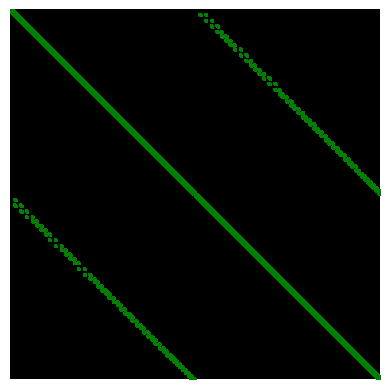

In [8]:
'''Visualise the KG matrix'''
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix

def plot_coo_matrix(m):
    if not isinstance(m, coo_matrix):
        m = coo_matrix(m)
    fig = plt.figure()
    ax = fig.add_subplot(111, facecolor='black')
    ax.plot(m.col, m.row, 's', color='green', ms=1)
    ax.set_xlim(0, m.shape[1])
    ax.set_ylim(0, m.shape[0])
    ax.set_aspect('equal')
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.invert_yaxis()
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    return ax

plot_coo_matrix(KGuu)

'''CONDITION NUMBER CHECK'''
def condition_check(A):
    ew1, ev1 = ssl.eigs(A, which='LM')
    print(f"lagest eig:{ew1}")
    print("SM starts")
    ew2, ev2 = ssl.eigs(A, sigma=1e9, which="LM")   #<--- takes a long time
    print(f"smallest eig:{ew1}")

    ew1 = abs(ew1)
    ew2 = abs(ew2)

    condA = ew1.max()/ew2.min()

    #PLOTTING EIGEN VECTORS
    # bl.plot_block(ev1[0::pf3.DOF, 0], "evBIGx1", meshOut, cst.CONSTS)
    # bl.plot_block(ev1[2::pf3.DOF, 1], "evBIGx2", meshOut, cst.CONSTS)
    # bl.plot_block(ev2[0::pf3.DOF, 0], "evSMALLx1", meshOut, cst.CONSTS)
    # bl.plot_block(ev2[2::pf3.DOF, 1], "evSMALLx2", meshOut, cst.CONSTS)

    return condA

print(f"condition num of KGuu: {condition_check(KGuu)}")

In [8]:
def buckling(sol:ty.Dict[str, object], meshOut:ty.Dict[str, object], KGuu:nt.NDArray[np.float64]):
    K_KAuu = sol["KC0uu"]-sol["KAuu"]
    n_modes = 10 #NOTE: we only care about the load multiplier being smaller/greater than 1, but leave the k higher for accuracy
    eigenvects = np.zeros((meshOut["N"], n_modes), dtype=np.complex128)
    initial = 1
    done = False

    '''step 1) searching for the order of magnitude range'''
    ew, ev = ssl.eigs(A=K_KAuu, M=KGuu, k=n_modes, which="LM", sigma=initial)
    nim = np.count_nonzero(np.imag(ew))
    if nim==len(ew): #All results are non-real
        ew1 = ew
        ev1 = ev #placeholder values needed not to return a purely imaginary vector
        while nim==len(ew1):
            prev_initial = initial
            initial*=10
            ew1, ev1 = ssl.eigs(A=K_KAuu, M=KGuu, k=n_modes, which="LM", sigma=initial)
            nim = np.count_nonzero(np.imag(ew1))
            print(f"nim: {nim}")
        ew = ew1 #we only update eigpairs if we know there are any real ones in the range
        ev = ev1
        lower_bound = prev_initial
        upper_bound = initial #since we are ascending
    else: #not all results are nonreal
        while nim<len(ew):
            prev_initial = initial
            initial/=10
            ew1, ev1 = ssl.eigs(A=K_KAuu, M=KGuu, k=n_modes, which="LM", sigma=initial)
            nim = np.count_nonzero(np.imag(ew1)) #again not to leave afully complex output
            print(f"nim: {nim}")
        lower_bound = initial
        upper_bound = prev_initial #since we are descending
    

    '''step 2) if we found our region'''
    for i in range(5): #three iterations should be enough for convergence
        print(f"lb: {lower_bound}, ub: {upper_bound}, nim: {nim}")
        sgm = (lower_bound+upper_bound)/2
        ew1, ev1 = ssl.eigs(A=K_KAuu, M=KGuu, k=n_modes, which="LM", sigma=sgm)
        nim = np.count_nonzero(np.imag(ew1))
        if nim==len(ew1): #We landed in a fully complex region
            lower_bound = sgm
        else: #we are in the complex region, we can go up
            upper_bound = sgm
            ew = ew1 #we only update eigpairs if we know there are any real ones in the range
            ev = ev1

    eigenvects[sol["bu"], :] = ev

    #reformatting the result as load multiplier, eigenvalues and an array of eigenvectors
    return min(ew[np.isclose(np.imag(ew), 0)]), ew, eigenvects.T

nim: 10
lb: 0.1, ub: 1, nim: 10
lb: 0.55, ub: 1, nim: 10
lb: 0.55, ub: 0.775, nim: 6
lb: 0.55, ub: 0.6625000000000001, nim: 4
lb: 0.55, ub: 0.6062500000000001, nim: 8
buckling load multiplier: (0.55554297550579+0j)
eigenvalues for buckling: [0.59222753+0.j         0.55554298+0.j         0.61113554+0.j
 0.6177556 +0.j         0.60993323+0.j         0.54108224-0.02169162j
 0.54108224+0.02169162j 0.56484682-0.04075201j 0.56484682+0.04075201j
 0.61827032+0.j        ]


c:\Users\marri\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\contour.py:1568: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmax = z.max().astype(float)
c:\Users\marri\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\contour.py:1569: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmin = z.min().astype(float)
c:\Users\marri\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\contour.py:1234: ComplexWarning: Casting complex values to real discards the imaginary part
  self.levels = np.asarray(levels_arg, np.float64)
c:\Users\marri\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2820: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


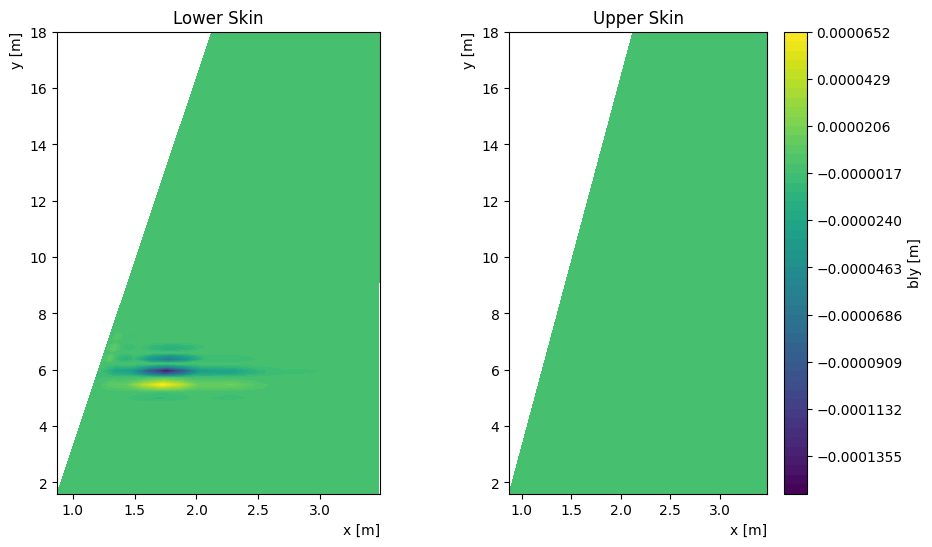

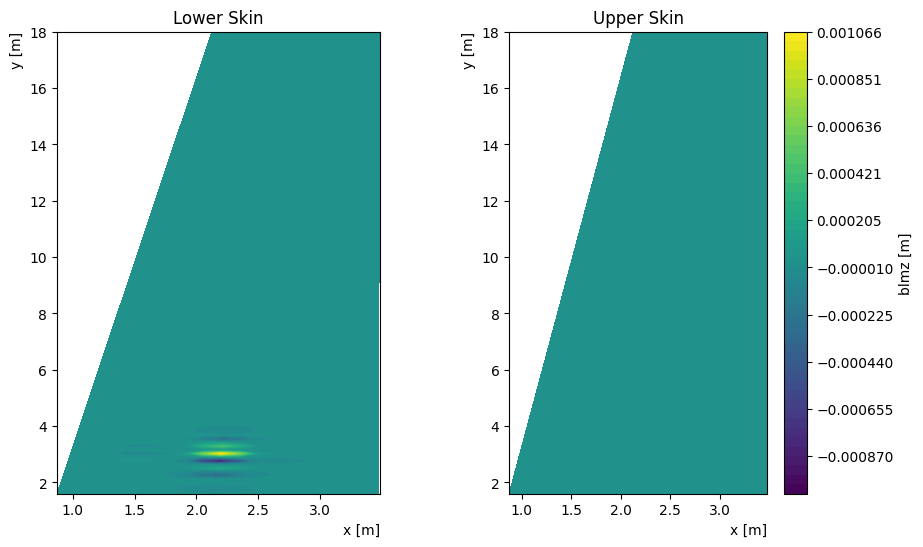

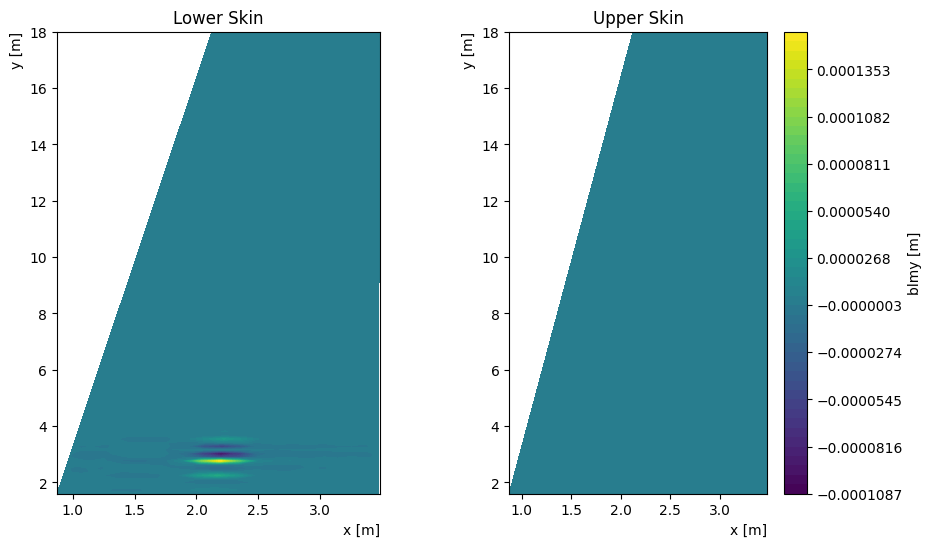

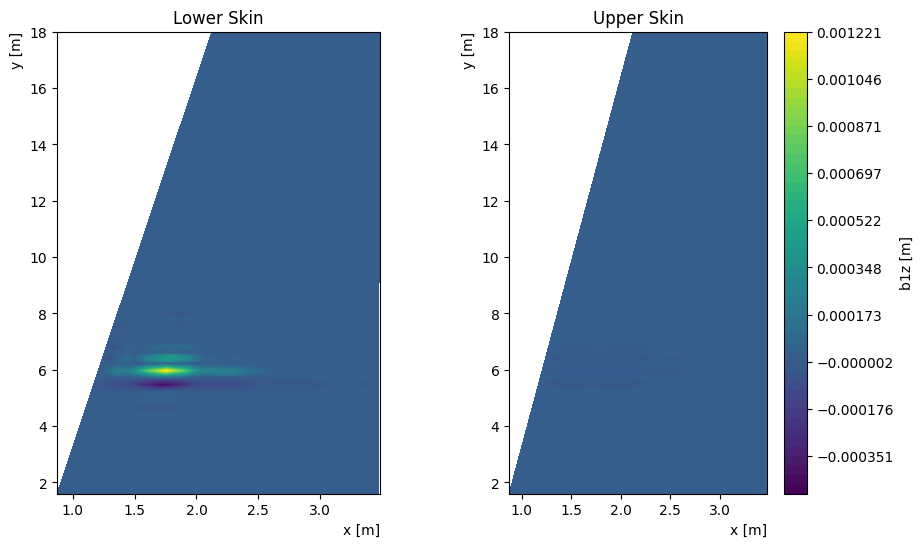

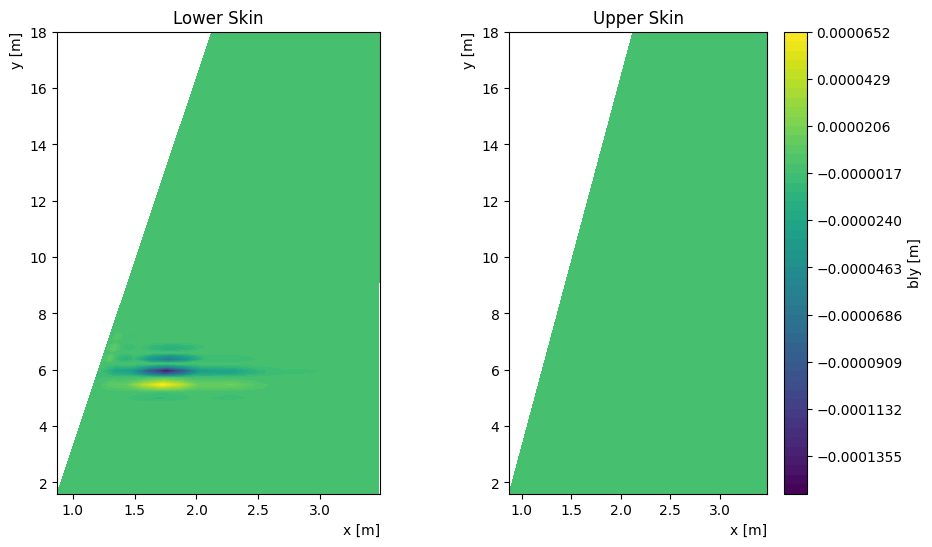

In [9]:
load_mult, ew, ev = buckling(sol, meshOut, KGuu)
print(f"buckling load multiplier: {load_mult}")
print(f"eigenvalues for buckling: {ew}")
bl.plot_block(ev[0, 2::pf3.DOF], "blmz", meshOut, cst.CONSTS, "m")
bl.plot_block(ev[0, 1::pf3.DOF], "blmy", meshOut, cst.CONSTS, "m")
bl.plot_block(ev[1, 2::pf3.DOF], "b1z", meshOut, cst.CONSTS, "m")
bl.plot_block(ev[1, 1::pf3.DOF], "bly", meshOut, cst.CONSTS, "m")

In [10]:
def natfreq(sol:ty.Dict[str, object], meshOut:ty.Dict[str, object]):
    K_KAuu = sol["KC0uu"]-sol["KAuu"]
    Muu = meshOut["M"][sol["bu"], :][:, sol["bu"]]
    n_modes=7#TODO: How many to use
    eigenvects = np.zeros((meshOut["N"], n_modes), dtype=np.complex128)

    ew, ev = ssl.eigs(A=K_KAuu, M=Muu, k=n_modes, which="LM", sigma=-1.) #TODO: copy pasted. verify it still holds
    eigenvects[sol["bu"], :] = ev

    #reformatting the result as omega_ns and an array of eigenvectors
    return ew**.5, eigenvects.T


natural frequencies: [0.        +1.43795035j 0.8915267 +0.j         0.90500723+0.j
 0.90600243+0.j         0.91273609+0.j         0.91735279+0.j
 0.92942528+0.j        ]


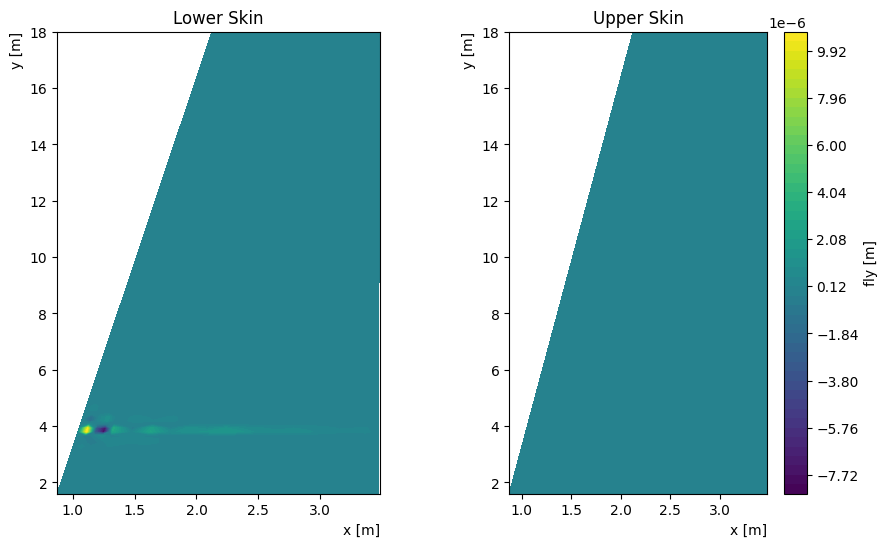

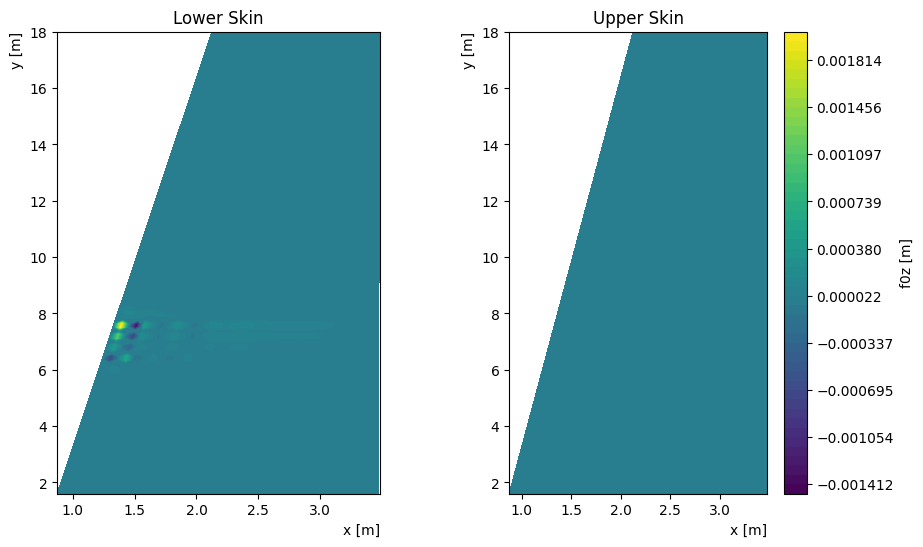

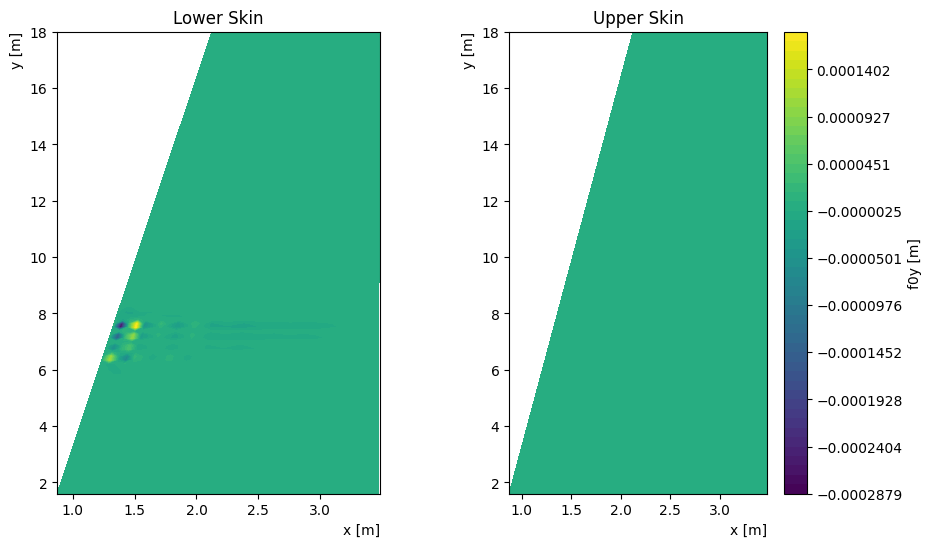

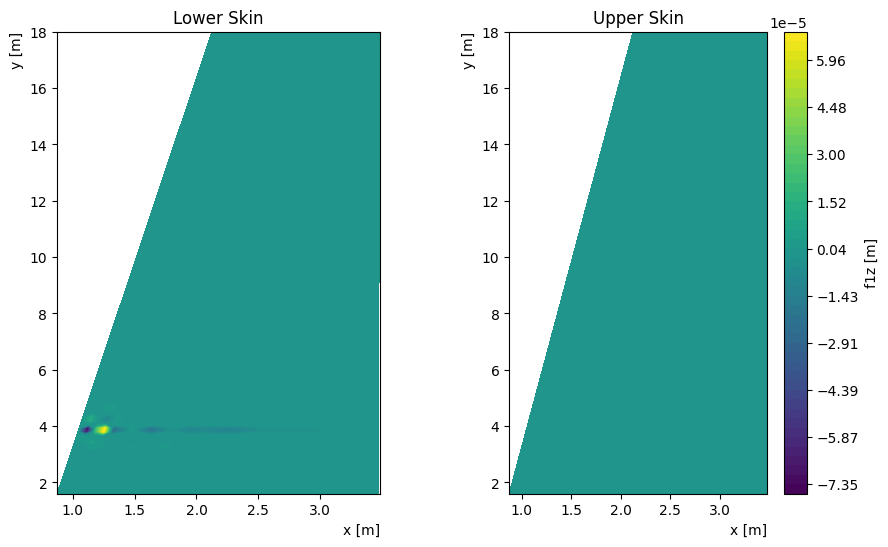

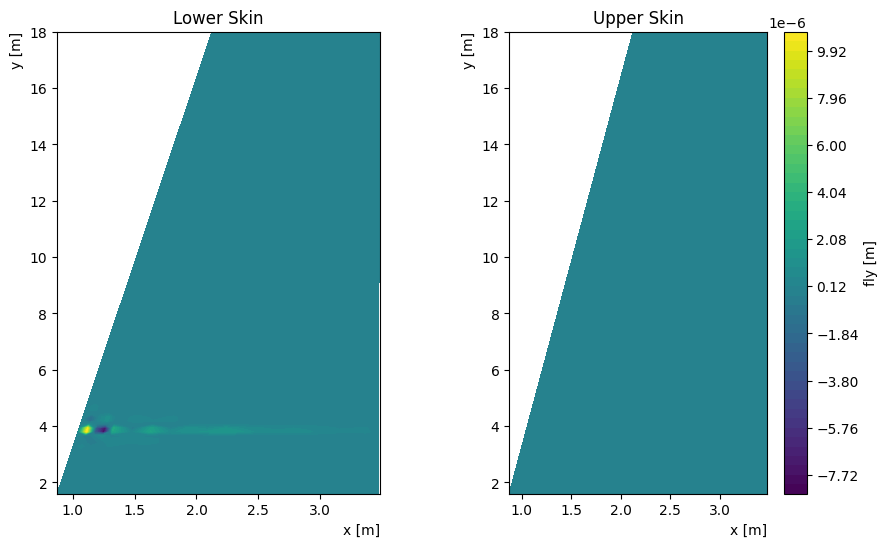

In [11]:
omega_n, omega_v = natfreq(sol, meshOut)

print(f"natural frequencies: {omega_n}")
bl.plot_block(omega_v[0, 2::pf3.DOF], "f0z", meshOut, cst.CONSTS, "m")
bl.plot_block(omega_v[0, 1::pf3.DOF], "f0y", meshOut, cst.CONSTS, "m")
bl.plot_block(omega_v[1, 2::pf3.DOF], "f1z", meshOut, cst.CONSTS, "m")
bl.plot_block(omega_v[1, 1::pf3.DOF], "fly", meshOut, cst.CONSTS, "m")

## Stress Analysis

In [13]:
class BeamPlotData():
    def __init__(self, node1, node2, tau, buckl, sgm):
        self.node1 = node1
        self.node2 = node2
        self.sgm = sgm
        self.tau = tau
        self.buc = buckl

def beam_stresses(sizerVars:ty.Dict[str, object], meshOut:ty.Dict[str, object], targetStressDict:ty.Dict[str, ty.Dict[str, object]],
                  codes:ty.Dict[str, str], csts:ty.Dict[str, object])->ty.List[BeamPlotData]:
    '''
    targetStressDict has a format of {eleid:{"sgm":<max normal stress margin>, "buc":<bucklin margin>, "tau":<max shear stress margin>}}
    '''
    beams2plot = list()
    for beam in meshOut["elements"]["beam"]: #at this tage the beam finte will have already been updated
        "0) interpreting the internal forces"
        Nxe1, Vye1, Vze1, Txe1, Mye1, Mze1, Nxe2, Vye2, Vze2, Txe2, Mye2, Mze2 = beam.probe.finte
        assert np.isclose(Nxe1, -Nxe2)
        assert np.isclose(Txe1, -Txe2)
        assert np.isclose(Vye1, -Vye2)
        assert np.isclose(Vze1, -Vze2)
        #from basic equilibrium
        Nxe = Nxe2 #due to sign convention
        Vye = Vye2
        Vze = Vze2
        Txe = Txe2

        "1) division between rails and tubes - different Q"
        if beam.eleid == codes["rail"]: #rails - full circular cross section
            Q = csts["DIN"]**3/12
            rout = csts["DIN"]/2
            w = csts["DIN"]
            sigmay = csts["SIGMAY_STEEL"]
            tauy = csts["TAUY_STEEL"]
        else: #tube elements
            rout = csts["TRUSS_R"]
            code2var = {
                codes["LETE"]:"fLETE",
                codes["spar"]:"fspar",
                codes["rib"]:"frib",
                codes["lg"]:"flg"
            }
            fti = sizerVars[code2var[beam.eleid]]
            Q = 2*rout**3*fti
            w = fti*rout*2 #width for shear - we have 2 thicknesses for tubes
            sigmay = csts["SIGMAY_ALU"]
            tauy = csts["TAUY_ALU"]
        
        "2) For circulars there exists an analytical solution of the optimisation for max stress, requires this moment interpretation:"
        #for bending moments we have to consider 3 locations: edges and extremum of Mz**2+My**2
        Mye = lambda eta: (Mye2+Mye1)*eta-Mye1
        Mze = lambda eta: (Mze2+Mze1)*eta-Mze1
        denominator = (Mye2+Mye1)**2+(Mze2+Mze1)**2 #we need to manually filter out 0 or cancelling moments
        if denominator:
            etas = np.array([0, (Mye1*(Mye2+Mye1)+Mze1*(Mze2+Mze1))/(denominator), 1])
        else:
            etas = np.array([0,1])
        moments_pythagoras = max(np.sqrt(Mye(etas)**2+Mze(etas)**2))

        "3) Obtining the ther necessary parameters"
        J = beam.beamprop.J
        A = beam.beamprop.A
        assert np.isclose(beam.beamprop.Iyy, beam.beamprop.Izz) #we have a tube moments of inertia same, use whichever
        I = beam.beamprop.Iyy
        E = beam.beamprop.E
        L = beam.length

        "4) Stress formulae from sept 20 page"
        tau_max = abs(Txe)*rout/J+np.sqrt(Vye**2+Vze**2)*Q/I/w #strictly positive
        sigma_min = -rout/I*moments_pythagoras+Nxe/A
        sigma_max = rout/I*moments_pythagoras+Nxe/A
        #Euler-Jhonson buckling, using sigma_y for Jhonson parabola to capture issues with operating close to yield strength
        k=.5 #we use only fixed joints (for now)
        if k*L*np.sqrt(A/I) > np.sqrt(2*np.pi**2*E/sigmay): #critical slenderness ratio check
            sigma_cr = np.pi**2*E*I/k**2/L**2/A #euler buckling
        else:
            sigma_cr = sigmay*(1-sigmay*k**2*L**2*A/I/4/np.pi**2/E) #jhonson's parabola

        "5) obtaining failure stress ratios"
        r_b = -sigma_min/sigma_cr #this way tension will display as  further from fail
        r_t = tau_max/tauy
        r_s = max(abs(sigma_min), abs(sigma_max))/sigmay

        "6) most constraining value updates"
        if r_t>targetStressDict[beam.eleid]["tau"]:
            targetStressDict[beam.eleid]["tau"] = r_t
        if r_b>targetStressDict[beam.eleid]["buc"]:
            targetStressDict[beam.eleid]["buc"] = r_b
        if r_s>targetStressDict[beam.eleid]["sgm"]:
            targetStressDict[beam.eleid]["sgm"] = r_s
        
        "7) Saving the beam to be plotted"
        node1 = meshOut["nid_pos"][beam.n1]
        node2 = meshOut["nid_pos"][beam.n2]
        beams2plot.append(BeamPlotData(node1, node2, r_t, r_b, r_s))
    return beams2plot

In [14]:
tsd = {cst.CODES["rail"]:{"buc":0, "tau":0, "sgm":0}, cst.CODES["LETE"]:{"buc":0, "tau":0, "sgm":0}, 
       cst.CODES["lg"]:{"buc":0, "tau":0, "sgm":0}, cst.CODES["rib"]:{"buc":0, "tau":0, "sgm":0}, cst.CODES["spar"]:{"buc":0, "tau":0, "sgm":0},}

beams2plot = beam_stresses(cst.INITIAL, meshOut, tsd, cst.CODES, cst.CONSTS)
print(tsd)

C:\Users\marri\AppData\Local\Temp\ipykernel_2008\2521846058.py:74: RuntimeWarning: invalid value encountered in sqrt
  if k*L*np.sqrt(A/I) > np.sqrt(2*np.pi**2*E/sigmay): #critical slenderness ratio check


{'rl': {'buc': 0.8893559890544702, 'tau': 0.3304558766360462, 'sgm': 0.8260171341757302}, 'lt': {'buc': 0.13092617821447566, 'tau': 0, 'sgm': 0.14994134041855386}, 'lg': {'buc': 0.11039457221846177, 'tau': 0, 'sgm': 0.11697389254760883}, 'rb': {'buc': 0.08633151064341615, 'tau': 0, 'sgm': 0.08661724699928752}, 'sp': {'buc': 0.12009705648631992, 'tau': 0, 'sgm': 0.12434456678598196}}


In [15]:
def rotate_2_global(ele, xe, ye, ze):
    xg = ele.r11*xe+ele.r12*ye+ele.r13*ze
    yg = ele.r21*xe+ele.r22*ye+ele.r23*ze
    zg = ele.r31*xe+ele.r32*ye+ele.r33*ze
    return xg, yg, zg

def map_an_idgrig(idgrid:nt.NDArray[np.int32]):
    idgrid_map = {}
    for i in range(idgrid.shape[0]):
        for j in range(idgrid.shape[1]):
            idgrid_map[idgrid[i,j]] = (i,j)
    return idgrid_map

def assign_to_crossec(nids:ty.List[int], map_:ty.Dict[int, ty.Tuple[int, int]]):
    idcoords = [map_[nid] for nid in nids]
    idx0s = [idcoord[0] for idcoord in idcoords]
    idx1s = [idcoord[1] for idcoord in idcoords]
    idx_crossec = min(idx0s) #since we have one cross section less than nodes, we assign the element to the lower index
    #before return check that the element is indeed a part of the grid
    assert all(idx0 in [max(idx0s), idx_crossec] for idx0 in idx0s)
    assert all(idx1 in [max(idx1s), min(idx1s)] for idx1 in idx1s)
    return idx_crossec

def obtain_cross_sections(meshOut:ty.Dict[str, object]):
    #mapping the idgrids so that we can obtain the positions in the idgrid for each quad
    top_idgrid = meshOut["ids"]["skinTop"]
    bot_idgrid = meshOut["ids"]["skinBot"]
    map_top = map_an_idgrig(top_idgrid)
    map_bot = map_an_idgrig(bot_idgrid)
    nid_pos = meshOut["nid_pos"]
    #a map allowing us to check whether we are on the top sheet or below
    top_bot_map = dict(zip(map_top.keys(), [True]*len(map_top))) | dict(zip(map_bot.keys(), [False]*len(map_top)))

    #the lists that will house the cross sections
    assert bot_idgrid.shape[0] == top_idgrid.shape[0] #so that we even get symmetric cross sections
    cross_sections_top = [[] for i in range(top_idgrid.shape[0]-1)] #formatted as in the grid, edge elements are on the edge, has to be increasing in x
    cross_sections_bot = [[] for i in range(bot_idgrid.shape[0]-1)] #formatted as in the grid, edge elements are on the edge, has to be increasing in x

    #iterating through every element and assigning it to a cross section
    for quad in meshOut["elements"]["quad"]:
        nids = [nid_pos[quad.n1], nid_pos[quad.n2], nid_pos[quad.n3], nid_pos[quad.n4]]
        if all([top_bot_map[nid] for nid in nids]): #if on the top
            idx = assign_to_crossec(nids, map_top)
            cross_sections_top[idx].append(quad)
        elif all([top_bot_map[nid] for nid in nids])==False: #if on the bottom
            cross_sections_bot[assign_to_crossec(nids, map_bot)].append(quad)
        else:
            raise AssertionError("The quad should belong to either the top or the bottom skin, not both, nor neither!")
        
    return cross_sections_top, cross_sections_bot

class InterpretedCrossSection():
    def __init__(self):
        self.booms_top:ty.List[ty.List[float, gcl.Point2D]] = list() #boom area, boom coordinates
        self.booms_bot:ty.List[ty.List[float, gcl.Point2D]] = list() #boom area, boom coordinates
        self.centroid = gcl.Point2D(0,0)
        self.Ixx = 0
        self.Izz = 0
        self.Ixz = 0
        self.Fx = 0
        self.Fy = 0
        self.Fz = 0
        self.Mx = 0
        self.My = 0
        self.Mz = 0
        self.sigma_top:ty.List[float] = list()
        self.sigma_bot:ty.List[float] = list()
        self.tau_top:ty.List[float] = list()
        self.tau_bot:ty.List[float] = list()

class NodeCoordsFint():
    def __init__(self, ncoord:nt.NDArray[np.float64], finte:nt.NDArray[np.float64], ele:p3g.QuadWithProp):
        self.x = ncoord[0]
        self.y = ncoord[1]
        self.z = ncoord[2]
        self.Fx, self.Fy, self.Fz = rotate_2_global(ele, finte[0], finte[1], finte[2])
        self.Mx, self.My, self.Mz = rotate_2_global(ele, finte[3], finte[4], finte[5])


def eles_to_booms(element_chain:ty.List[p3g.QuadWithProp], csts:ty.Dict[str, object], meshOut:ty.Dict[str, object], sizerVars:ty.Dict[str, float]):
    ncoords, nid_pos = (meshOut[k] for k in ["ncoords", "nid_pos"])

    global_front_ncfs = list()
    for ele in element_chain:
        nids = [nid_pos[ele.n1], nid_pos[ele.n2], nid_pos[ele.n3], nid_pos[ele.n4]]
        ncfs = [NodeCoordsFint(ncoords[nid], ele.probe.finte[6*i:6*i+6], ele) for i, nid in enumerate(nids)]
        "sorting out the nodes to front/rear ones"
        y_boundary = sum([ncf.y for ncf in ncfs])/len(ncfs) #an average value of y - those above go to the "front of the cross sec"
        front_ncfs, rear_ncfs = list(), list()
        for ncf in ncfs:
            if ncf.y>y_boundary:
                front_ncfs.append(ncf)
            else:
                rear_ncfs.append(ncf)
        "len and equilibrium checks"
        assert len(front_ncfs)==2
        assert len(rear_ncfs)==2
        assert np.isclose(sum(ncf.Fx for ncf in front_ncfs+rear_ncfs), 0, atol=1.), f"{[ncf.Fx for ncf in front_ncfs+rear_ncfs]}, {(front_ncfs[0].x, front_ncfs[0].y, front_ncfs[0].z)}"
        assert np.isclose(sum(ncf.Fy for ncf in front_ncfs+rear_ncfs), 0, atol=1.), f"{[ncf.Fy for ncf in front_ncfs+rear_ncfs]}"
        assert np.isclose(sum(ncf.Fz for ncf in front_ncfs+rear_ncfs), 0, atol=1.), f"{[ncf.Fz for ncf in front_ncfs+rear_ncfs]}"
        moment_arm = (front_ncfs[0].y-rear_ncfs[0].y)/2
        global_front_ncfs+=front_ncfs #obtaining the nodes that matter for internal force summation
    #global_front_ncfs.sort(key=lambda item:item.x)

    "collapsing the nodes of 2 eles at the same coords into themselves"
    collapsed_ncfs = [global_front_ncfs[0]]
    for ncf1, ncf2 in zip(global_front_ncfs[1:-2:2], global_front_ncfs[2:-1:2]):
        assert np.isclose(ncf1.x, ncf2.x), f"{ncf1.x}, {ncf2.x}"
        assert np.isclose(ncf1.y, ncf2.y), f"{ncf1.y}, {ncf2.y}"
        assert np.isclose(ncf1.z, ncf2.z), f"{ncf1.z}, {ncf2.z}"
        collapsed_ncfs.append(ncf1)
        #summing up fints at the common node
        collapsed_ncfs[-1].Fx += ncf2.Fx
        collapsed_ncfs[-1].Fy += ncf2.Fy
        collapsed_ncfs[-1].Fz += ncf2.Fz
        collapsed_ncfs[-1].Mx += ncf2.Mx
        collapsed_ncfs[-1].My += ncf2.My
        collapsed_ncfs[-1].Mz += ncf2.Mz
    collapsed_ncfs.append(global_front_ncfs[-1])

    "calculating boom areas (without skin contrib), based on stiffener spacing and coordinates"
    booms = [[0, gcl.Point2D(ncf.x, ncf.z)] for ncf in collapsed_ncfs] #cross section is in yz
    dists = [boom1[1].pythagoras(boom2[1]) for boom1, boom2 in zip(booms[:-1], booms[1:])]
    #now what part of length "corresponds to" which boom
    lens2booms = [dists[0]/2]
    for dist1, dist2 in zip(dists[:-1], dists[1:]):
        lens2booms.append((dist1+dist2)/2)
    lens2booms.append(dists[-1]/2)
    #now actual boom areas
    B_per_meter = csts["ORTHG_H"]*sizerVars["tskin"]/sizerVars["csp"]
    for i in range(len(booms)):
        booms[i][0] = lens2booms[i]*B_per_meter
    #make sure the booms are in the correct direction (which they should be due to generation)
    assert all([b1[1].x<b2[1].x for b1, b2 in zip(booms[:-1], booms[1:])])

    "summing the internal forces - around the element chain centroid"
    skin_centroids = [gcl.Point2D.midpoint([boom1[1], boom2[1]]) for boom1, boom2 in zip(booms[:-1], booms[1:])]
    skin_areas = [sizerVars["tskin"]*dist for dist in dists]
    centroid, Atot = gcl.centroid2D([boom[1] for boom in booms]+skin_centroids, [boom[0] for boom in booms]+skin_areas, True)
    Fx = sum(collapsed_ncf.Fx for collapsed_ncf in collapsed_ncfs)
    Fy = sum(collapsed_ncf.Fy for collapsed_ncf in collapsed_ncfs)
    Fz = sum(collapsed_ncf.Fz for collapsed_ncf in collapsed_ncfs)
    Mx = sum(cncf.Fz*moment_arm for cncf in collapsed_ncfs)-sum(cncf.Fy*(cncf.z-centroid.y) for cncf in collapsed_ncfs)+sum(cncf.Mx for cncf in collapsed_ncfs)
    My = sum(-cncf.Fz*(cncf.x-centroid.x) for cncf in collapsed_ncfs)+sum(cncf.Fx*(cncf.z-centroid.y) for cncf in collapsed_ncfs)+sum(cncf.My for cncf in collapsed_ncfs)
    Mz = sum(-cncf.Fx*moment_arm for cncf in collapsed_ncfs)+sum(cncf.Fy*(cncf.x-centroid.x) for cncf in collapsed_ncfs)+sum(cncf.Mz for cncf in collapsed_ncfs)

    "Iyy, Izz, Iyz calculations"
    #1) Ixx
    Ixx = sum(sa*(sc.y-centroid.y)**2 for sa, sc in zip(skin_areas, skin_centroids))
    Ixx += sum(boom[0]*(boom[1].y-centroid.y)**2 for boom in booms)
    Ixx += sum(sizerVars["tskin"]*dist*(boom1[1].y-boom2[1].y)**2/12 for dist, boom1, boom2 in zip(dists, booms[:-1], booms[1:]))
    #2) Izz
    Izz = sum(sa*(sc.x-centroid.x)**2 for sa, sc in zip(skin_areas, skin_centroids))
    Izz += sum(boom[0]*(boom[1].x-centroid.x)**2 for boom in booms)
    Izz += sum(sizerVars["tskin"]*dist*(boom1[1].x-boom2[1].x)**2/12 for dist, boom1, boom2 in zip(dists, booms[:-1], booms[1:]))
    #3) Ixz - all element contributions symmetric hence zero, only parallel axis terms
    Ixz = sum(sa*(sc.y-centroid.y)*(sc.x-centroid.x) for sa, sc in zip(skin_areas, skin_centroids))
    Ixz += sum(boom[0]*(boom[1].x-centroid.x)*(boom[1].y-centroid.y) for boom in booms)

    return booms, centroid, Atot, Ixx, Izz, Ixz, Fx, Fy, Fz, Mx, My, Mz

def skin_contribs(booms:ty.List[ty.List[object]], sigmas:ty.List[float], tskin):
    #assume the booms are sorted
    bs = [boom1[1].pythagoras(boom2[1]) for boom1, boom2 in zip(booms[:-1], booms[1:])]
    for i in range(len(bs)):
        booms[i][0] += tskin*bs[i]/6*(2+sigmas[i+1]/sigmas[i])
        booms[i+1][0] += tskin*bs[i]/6*(2+sigmas[i]/sigmas[i+1])
    return booms

def idealised_properties(booms:ty.List[ty.List[object]]):
    tot_A = sum([boom[0] for boom in booms])
    centroid = gcl.Point2D(sum([boom[0]*boom[1].x  for boom in booms])/tot_A,
                           sum([boom[0]*boom[1].y  for boom in booms])/tot_A)
    Ixx = sum([boom[0]*(boom[1].y-centroid.y)**2 for boom in booms])
    Izz = sum([boom[0]*(boom[1].x-centroid.x)**2 for boom in booms])
    Ixz = sum([boom[0]*(boom[1].y-centroid.y)*(boom[1].x-centroid.x) for boom in booms])
    return centroid, Ixx, Izz, Ixz

def basic_shearfl(booms:ty.List[ty.List[object]], cx:float, cy:float, centroid:gcl.Point2D, Gt:float):
    qbs = np.zeros(len(booms))
    Mqbs = np.zeros(len(booms)-1) #see coefficient definitions on August 24th page
    qbdxs = np.zeros(len(booms)-1)
    qbdys = np.zeros(len(booms)-1)
    twists = np.zeros(len(booms)-1)

    for i, boom in enumerate(booms[:-1]):
        qbs[i+1] = qbs[i]+cx*boom[0]*(boom[1].x-centroid.x)+cy*boom[0]*(boom[1].y-centroid.y)
        #updating free variable vector components dependent on the basic shear
        qbdir = gcl.Direction2D.from_pts(boom[1], booms[i+1][1])
        boomdist = boom[1].pythagoras(booms[i+1][1])
        qbdxs[i] = qbs[i+1]*qbdir.x*boomdist
        qbdys[i] = qbs[i+1]*qbdir.y*boomdist
        boomdir=gcl.Direction2D.from_pts(centroid, boom[1])
        boomline = gcl.Line2D.from_pts(boom[1], booms[i+1][1])
        moment_sign = gcl.momentSign2D(boomdir, qbdir)
        moment_arm = boomline.point_distance(centroid)
        Mqbs[i] = moment_sign*moment_arm*boomdist*qbs[i+1]
        #twists[i] = moment_sign*qbs[i+1]/Gt/moment_arm
    
    diff = qbs[-1]+cx*booms[-1][0]*(booms[-1][1].x-centroid.x)+cy*booms[-1][0]*(booms[-1][1].y-centroid.y)
    assert np.isclose(diff, 0, atol=.05*max(abs(qbs))), f"{qbs}, {diff}"
    return qbs[1:], sum(Mqbs), sum(qbdxs), sum(qbdys)#, sum(twists)

def shear_coeffs(booms:ty.List[ty.List[object]], centroid:gcl.Point2D, Gt:float):
    '''matrix coefficients for the shear equations as derived on the August 24th page'''
    #intermediate quantities
    ls = [boom1[1].pythagoras(boom2[1]) for boom1, boom2 in zip(booms[:-1], booms[1:])] #distances between booms
    dirqs = [gcl.Direction2D.from_pts(boom1[1], boom2[1]) for boom1, boom2 in zip(booms[:-1], booms[1:])] #shear flow directions
    lineqs = [gcl.Line2D.from_pts(boom1[1], boom2[1]) for boom1, boom2 in zip(booms[:-1], booms[1:])] #shear flow lines
    hqs = [lineq.point_distance(centroid) for lineq in lineqs] #shear flow moment arm lengths
    #for now we reuse one of the normal directions, the curvature is so small that it really shouldn't matter
    dirtaus = [gcl.Direction2D.normal_towards(gcl.Direction2D.from_pts(boom[1], centroid), dirq) for boom, dirq in zip(booms, dirqs+[dirqs[-1]])] #local dir of transverse shear
    dircAs = [gcl.Direction2D.from_pts(centroid, boom[1]) for boom in booms]
    htaus = [gcl.Line2D(boom[1], dirtau).point_distance(centroid) for boom, dirtau in zip(booms, dirtaus)]

    #coefficients - we skin torque effects on transverse shear as twist is not computable (torsional constant) and moment makes like 2% difference
    _2Am = sum(l*h for l, h in zip(ls, hqs)) #the 2*Am coefficient which is sum(2*(1/2*l_i*h_i))=sum(l_i*h_i)
    cm = sum(htau*boom[0]*gcl.momentSign2D(dircA, dirtau) for htau, boom, dircA, dirtau in zip(htaus, booms, dircAs, dirtaus))
    Axfrac = sum(boom[0]*dirtau.x for boom, dirtau in zip(booms, dirtaus))
    Azfrac = sum(boom[0]*dirtau.y for boom, dirtau in zip(booms, dirtaus))
    intx = sum(dirq.x*l for dirq, l in zip(dirqs, ls))
    intz = sum(dirq.y*l for dirq, l in zip(dirqs, ls))

    return _2Am, cm, Axfrac, Azfrac, intx, intz


def physical_interpretation(meshOut:ty.Dict[str, object], top_sec:ty.List[p3g.QuadWithProp], bot_sec:ty.List[p3g.QuadWithProp], csts:ty.Dict[str, object], sizerVars:ty.Dict[str, float]):
    ncoords, nid_pos = (meshOut[k] for k in ["ncoords", "nid_pos"])
    ics= InterpretedCrossSection()

    "2) obtaining the boom areas and coordinates of top and bottom cross sections"
    booms_t, centroid_t, A_t, Ixx_t, Izz_t, Ixz_t, Fx_t, Fy_t, Fz_t, Mx_t, My_t, Mz_t = eles_to_booms(top_sec, csts, meshOut, sizerVars)
    booms_b, centroid_b, A_b, Ixx_b, Izz_b, Ixz_b, Fx_b, Fy_b, Fz_b, Mx_b, My_b, Mz_b = eles_to_booms(bot_sec, csts, meshOut, sizerVars)

    "3) obtaining global section properties"
    ics.centroid = gcl.centroid2D([centroid_t, centroid_b], [A_t, A_b])
    ics.Ixx = Ixx_t+Ixx_b+A_t*(centroid_t.y-ics.centroid.y)**2+A_b*(centroid_b.y-ics.centroid.y)**2
    ics.Izz = Izz_t+Izz_b+A_t*(centroid_t.x-ics.centroid.x)**2+A_b*(centroid_b.x-ics.centroid.x)**2
    ics.Ixz = Ixz_t+Ixz_b+A_t*(centroid_t.y-ics.centroid.y)*(centroid_t.x-ics.centroid.x)+A_b*(centroid_b.y-ics.centroid.y)*(centroid_b.x-ics.centroid.x)
    ics.Fx = Fx_t+Fx_b
    ics.Fy = Fy_t+Fy_b
    ics.Fz = Fz_t+Fz_b
    ics.Mx = Mx_t+Mx_b-Fy_t*(centroid_t.y-ics.centroid.y)-Fy_b*(centroid_b.y-ics.centroid.y)
    #TODO: Add a shear centre and calculate My about the shear centre
    ics.My = My_t+My_b-Fz_t*(centroid_t.x-ics.centroid.y)-Fz_b*(centroid_b.x-ics.centroid.y)+Fx_t*(centroid_t.y-ics.centroid.y)+Fx_b*(centroid_b.y-ics.centroid.y)
    ics.Mz = Mz_t+Mz_b

    "4) Normal stress and skin contributions"
    #We need to find the normal stresses for boom contributions
    sigma = lambda x,z: ics.Fy/(A_t+A_b)+((ics.Mz*ics.Ixx+ics.Mx*ics.Ixz)*(x-ics.centroid.x)-(ics.Mz*ics.Ixz+ics.Mx*ics.Izz)*(z-ics.centroid.y))/(ics.Ixx*ics.Izz-ics.Ixz**2) 
    ics.sigma_top = [sigma(boom[1].x, boom[1].y) for boom in booms_t] 
    ics.sigma_bot = [sigma(boom[1].x, boom[1].y) for boom in booms_b]
    ics.booms_top = skin_contribs(booms_t, ics.sigma_top, sizerVars["tskin"])
    ics.booms_bot = skin_contribs(booms_b, ics.sigma_bot, sizerVars["tskin"])
    
    "5) Shear solution as on August 24th-26th page"
    icentr, iIxx, iIzz, iIxz = idealised_properties(ics.booms_bot+ics.booms_top)
    qbcx = -(ics.Fx*iIxx)/(iIxx*iIzz-iIxz**2)
    qbcz = (ics.Fx*iIxz)/(iIxx*iIzz-iIxz**2)
    Gt = csts["E_ALU"]/2/(1+.3)*5/6*sizerVars["tskin"] #NOTE assume scf = 5/6
    qb_top, Mqb_top, qbdx_top, qbdz_top = basic_shearfl(ics.booms_top, qbcx, qbcz, icentr, Gt)
    qb_bot, Mqb_bot, qbdx_bot, qbdz_bot = basic_shearfl(ics.booms_bot, qbcx, qbcz, icentr, Gt)
    _2Am_t, cm_t, Axfr_t, Azfr_t, intx_t, intz_t = shear_coeffs(ics.booms_top, icentr, Gt)
    _2Am_b, cm_b, Axfr_b, Azfr_b, intx_b, intz_b = shear_coeffs(ics.booms_bot, icentr, Gt)

    shear_mat = np.matrix(f'''
    {cm_t} {cm_b} {_2Am_t} {_2Am_b};
    {Azfr_t} 0 {intz_t} 0;
    0 {Azfr_b} 0 {intz_b};
    {Axfr_t} {Axfr_b} {intx_t} {intx_b}
    ''')
    shear_free_vect = np.matrix(f'''{ics.My-Mqb_top-Mqb_bot}; {Fz_t-qbdz_top}; {Fz_b-qbdz_bot}; {ics.Fx-qbdx_top-qbdx_bot}''')
    tau_t, tau_b, qs0_t, qs0_b = np.linalg.inv(shear_mat) @ shear_free_vect

    for qb in qb_top:
        ics.tau_top.append(np.sqrt(tau_t[0,0]**2+((qs0_t[0,0]+qb)/sizerVars["tskin"])**2))
    for qb in qb_bot:
        ics.tau_bot.append(np.sqrt(tau_b[0,0]**2+((qs0_b[0,0]+qb)/sizerVars["tskin"])**2))

    return ics


In [32]:
cstop, csbot = obtain_cross_sections(meshOut)
crossecs:ty.List[InterpretedCrossSection] = list()
for cst_, csb_ in zip(cstop, csbot):
    crossecs.append(physical_interpretation(meshOut, cst_, csb_, cst.CONSTS, cst.INITIAL))

262373188.00018805
-262071966.39236695
522007241.02396023
517790069.2474164


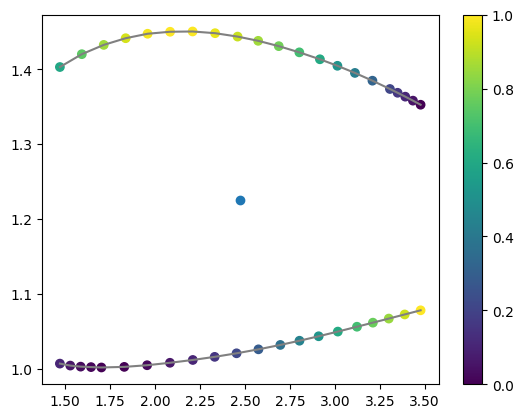

In [44]:
import matplotlib.pyplot as plt
cn = 60 #cross-section number
plt.plot([boom[1].x for boom in crossecs[cn].booms_bot], [boom[1].y for boom in crossecs[cn].booms_bot], c="gray")
plt.scatter([boom[1].x for boom in crossecs[cn].booms_bot], [boom[1].y for boom in crossecs[cn].booms_bot], c=crossecs[cn].sigma_bot)
plt.plot([boom[1].x for boom in crossecs[cn].booms_top], [boom[1].y for boom in crossecs[cn].booms_top], c="gray")
plt.scatter([boom[1].x for boom in crossecs[cn].booms_top], [boom[1].y for boom in crossecs[cn].booms_top], c=crossecs[cn].sigma_top)
plt.scatter([crossecs[cn].centroid.x], [crossecs[cn].centroid.y])
plt.colorbar()
print(max(crossecs[cn].sigma_top+crossecs[cn].sigma_bot))
print(min(crossecs[cn].sigma_top+crossecs[cn].sigma_bot))
print(max(crossecs[cn].tau_top+crossecs[cn].tau_bot))
print(min(crossecs[cn].tau_top+crossecs[cn].tau_bot))

### Pyvista

In [20]:
import pyvista
pyvista.set_plot_theme('document')
pyvista.set_jupyter_backend('trame')
pyvista.global_theme.window_size = [600, 400]
pyvista.global_theme.axes.show = True
pyvista.global_theme.anti_aliasing = 'fxaa'
pyvista.global_theme.show_scalar_bar = True

In [23]:
import pyvista as pv

edges = []
bucs = []
taus = []
sgms = []

for bpd in beams2plot:
    edges.append([bpd.node1, bpd.node2])
    bucs.append(bpd.buc)
    taus.append(bpd.tau)
    sgms.append(bpd.sgm)
    
padding = np.empty(len(edges), int) * 2
padding[:] = 2
edges_w_padding = np.vstack((padding, np.array(edges).T)).T
edges_w_padding

meshpv = pv.PolyData(meshOut["ncoords"], edges_w_padding)

line_width = np.ones(len(edges))
meshpv.plot(scalars=sgms,
            render_lines_as_tubes=True,
    style='wireframe',
    line_width=5,
    cmap='jet',
    show_scalar_bar=True,
    background='w',)
print(edges)

Widget(value='<iframe src="http://localhost:62279/index.html?ui=P_0x28393bc9280_4&reconnect=auto" class="pyvis…

[[4, 25], [25, 46], [46, 67], [67, 88], [88, 109], [109, 130], [130, 151], [151, 172], [172, 193], [193, 214], [214, 235], [235, 256], [256, 277], [277, 298], [298, 319], [319, 340], [340, 361], [361, 382], [382, 403], [403, 424], [424, 445], [445, 466], [466, 487], [487, 508], [508, 529], [529, 550], [550, 571], [571, 592], [592, 613], [613, 634], [634, 655], [655, 676], [676, 697], [697, 718], [718, 739], [739, 760], [760, 781], [781, 802], [802, 823], [823, 844], [844, 865], [865, 886], [886, 907], [907, 928], [928, 949], [949, 970], [970, 991], [991, 1012], [1012, 1033], [1033, 1054], [1054, 1075], [1075, 1096], [1096, 1117], [1117, 1138], [1138, 1159], [1159, 1180], [1180, 1201], [1201, 1222], [1222, 1243], [1243, 1264], [1264, 1285], [1285, 1306], [1306, 1327], [1327, 1348], [1348, 1369], [1369, 1390], [1390, 1411], [1411, 1432], [1432, 1453], [1453, 1474], [1474, 1495], [1495, 1516], [1516, 1537], [1537, 1558], [1558, 1579], [1579, 1600], [1600, 1621], [1621, 1642], [1642, 1663]

# Post Processor - internal forces and margins for every failure mode

In [6]:
def flutter_block(consts:ty.Dict[str, object], meshOuts:ty.Dict[str, object], lc:ty.Dict[str, object], sol:ty.Dict[str, object]):
    les, tes, up, M, N = [meshOuts[k] for k in ["les", "tes", "up", "M", "N"]]
    foils, bres, cres, velocities, airfs = [consts[k] for k in ["FOILS", "BRES", "CRES", "VELOCITIES", "FOILS"]]
    op, nlg = [lc[k] for k in ["op", "nlg"]]
    ncoords_s, ids_s, bu, Kuu = [sol[k] for k in ["ncoords_s", "ids_s", "bu", "KC0uu"]]
    airplane, vlm, forces, moments = ls.vlm(les, tes, airfs, op, bres, cres, np.zeros(len(airfs)))
    W, Fext = ls.aero2fem(vlm, ncoords_s, ids_s, N, pf3.DOF)
    W_u_to_p = ls.fem2aero(les, np.zeros(len(foils)), ncoords_s, ids_s, N, pf3.DOF)

    #natural freqs for flutter
    return ls.flutter_omegans(velocities, M, bu, W_u_to_p, Kuu, W, les, tes, airfs, op, up.fft.y, bres, cres)


In [23]:
def rotate_2_local(ele, id_node, ncoords):
    xg, yg, zg = ncoords[id_node]
    xe = ele.r11*xg+ele.r21*yg+ele.r31*zg
    ye = ele.r12*xg+ele.r22*yg+ele.r32*zg
    ze = ele.r13*xg+ele.r23*yg+ele.r33*zg
    return xe, ye, ze

def quad_plate_stress(ele, finte_part, wxe, wye):
    Fxe, Fye, Fze, Mxe, Mye, Mze = np.asanyarray(finte_part)

    #plane stresses
    sx = Fxe/wye/ele.shellprop.h
    sy = Fye/wxe/ele.shellprop.h
    sxC = sx-abs(Mye/(wye*ele.shellprop.h**2/12)/2)
    sxT = sx+abs(Mye/(wye*ele.shellprop.h**2/12)/2)
    syC = sy-abs(Mxe/(wxe*ele.shellprop.h**2/12)/2)
    syT = sy+abs(Mxe/(wxe*ele.shellprop.h**2/12)/2)

    #out-of-plane stresses TODO verify
    tz = np.abs(Fze)/min(wye, wxe)/ele.shellprop.h #we make the worse wall assumption, that the shear flows in a different direction than we might want it to 
    #for now, we assume no modification due to Mze TODO add that
    return np.array([sxC, sxT, syC, syT, tz, sx, sy]) #we keep sx, sy for future mohr circle caluclations


'''COPYPASTE THIS TO blocks.py ONCE DONE!!!'''
def stress_block(defl:ty.Dict[str, nt.NDArray[np.float64]], meshOuts:ty.Dict[str,object], 
                         codes:ty.Dict[str,str], sizerVals:ty.Dict[str,str], consts:ty.Dict[str,object], debug=False):
    rfl, din = tuple(consts[k] for k in ['RIB_FLANGE', 'DIN'])
    tsp, tsk, trb, tpl = tuple(sizerVals[k] for k in ['tspar', 'tskin', 'trib', 'tpan'])
    KC0, M, N, x, y, z, mesh, up, ids, pts, nid_pos, ncoords = tuple(meshOuts[k] for k in ['KC0', 'M', 'N', 'x', 'y', 'z', 'mesh', 'up', 'ids', 'pts', 'nid_pos', 'ncoords'])
    eleDict, KGv, KGr, KGc, ncoords_flatten = tuple(meshOuts[k] for k in ['elements', 'KGv', 'KGr', 'KGc', 'ncoords_flatten'])
    fi = np.zeros(meshOuts["N"])
    u, bu, bk, Kuu = tuple(defl[k] for k in ["u", "bu", "bk", "KC0uu"])

    '''INTERNAL LOADS'''
    #only for quads and beams as of now - that's all we are using
    sigma_most = {'quad':{codes["skin"]:[], codes["panelRib"]:[], codes["panelPlate"]:[], codes["spar"]:[]},
                'beam':{codes["rail"]:[], codes["panelFlange"]:[]}}
    tau_most = {'quad':{codes["skin"]:[], codes["panelRib"]:[], codes["panelPlate"]:[], codes["spar"]:[]},
                'beam':{codes["rail"]:[], codes["panelFlange"]:[]}}
    sorted_eles = {'quad':{codes["skin"]:[], codes["panelRib"]:[], codes["panelPlate"]:[], codes["spar"]:[]},
                'beam':{codes["rail"]:[], codes["panelFlange"]:[]}}
    for quad in eleDict["quad"]:
        # NOTE update affects the Quad4RProbe class attribute ue
        quad.update_probe_ue(u)
        quad.update_probe_xe(ncoords_flatten)
        quad.update_KG(KGr, KGc, KGv, quad.shellprop)
        quad.update_probe_finte(quad.shellprop)
        quad.update_fint(fi, quad.shellprop)

        "stresses"
        #transferring nodes into local coord system
        xe1, ye1, ze1 = rotate_2_local(quad, nid_pos[quad.n1], ncoords)
        xe2, ye2, ze2 = rotate_2_local(quad, nid_pos[quad.n2], ncoords)
        xe3, ye3, ze3 = rotate_2_local(quad, nid_pos[quad.n3], ncoords)
        xe4, ye4, ze4 = rotate_2_local(quad, nid_pos[quad.n4], ncoords)

        #getting the widths of the element - we have some very elongated element, so necessary to consider
        #current algorithm is wxe*wye=SA, wxe~max(xes)-min(xes), wyeb similarly
        #area by two cross products
        SA = .5*np.linalg.norm(np.cross([xe4-xe1, ye4-ye1, ze4-ze1], [xe2-xe1, ye2-ye1, ze2-ze1]))+.5*np.linalg.norm(np.cross([xe1-xe2, ye1-ye2, ze1-ze2], [xe3-xe2, ye3-ye2, ze3-ze2]))
        wxeprop=max(xe1, xe2, xe3, xe4)-min(xe1, xe2, xe3, xe4)
        wyeprop=max(ye1, ye2, ye3, ye4)-min(ye1, ye2, ye3, ye4)
        c = np.sqrt(SA/wxeprop/wyeprop)
        wxe = wxeprop*c
        wye = wyeprop*c

        #stress calculation for the four nodes - then averaged
        stresses1 = quad_plate_stress(quad, quad.probe.finte[:6], wxe, wye)
        stresses2 = quad_plate_stress(quad, quad.probe.finte[6:12], wxe, wye)
        stresses3 = quad_plate_stress(quad, quad.probe.finte[12:18], wxe, wye)
        stresses4 = quad_plate_stress(quad, quad.probe.finte[18:], wxe, wye)
        stresses = (stresses1+stresses2+stresses3+stresses4)/4

        #further individual post-processing and saving of the results
        if quad.eleid == codes["skin"]:
            tau_most["quad"][codes["skin"]].append(stresses[4])
            sigma_most["quad"][codes["skin"]].append(max(np.abs(stresses[:4])))
            sorted_eles["quad"][codes["skin"]].append(quad)

        elif quad.eleid == codes["panelRib"]:
            tau_most["quad"][codes["panelRib"]].append(stresses[4])
            sigma_most["quad"][codes["panelRib"]].append(max(np.abs(stresses[:4])))
            sorted_eles["quad"][codes["panelRib"]].append(quad)

        elif quad.eleid == codes["panelPlate"]:
            tau_most["quad"][codes["panelPlate"]].append(stresses[4])
            sigma_most["quad"][codes["panelPlate"]].append(max(np.abs(stresses[:4])))
            sorted_eles["quad"][codes["panelPlate"]].append(quad)

        elif quad.eleid == codes["spar"]:
            tau_most["quad"][codes["spar"]].append(stresses[4])
            sigma_most["quad"][codes["spar"]].append(max(np.abs(stresses[:4])))
            sorted_eles["quad"][codes["spar"]].append(quad)

        else: raise NotImplementedError(f"A quad element of eleid {quad.eleid} not accounted for in post-processing!")

    for beam in eleDict["beam"]:
        beam.update_probe_ue(u)
        beam.update_probe_xe(ncoords_flatten)
        beam.update_KG(KGr, KGc, KGv, beam.beamprop, 0) #here only values change
        beam.update_probe_finte(beam.beamprop)
        beam.update_fint(fi, beam.beamprop) 

        "stresses"
        Fx1, Fy1, Fz1, Mx1, My1, Mz1 = beam.probe.finte[:6]

        A, J, Iyy, Izz = beam.beamprop.A, beam.beamprop.J, beam.beamprop.Iyy, beam.beamprop.Izz 

        if beam.eleid == codes["rail"]:
            #normal stress
            sigma_most["beam"][codes["rail"]].append(abs(Fx1)/A+din/2*np.sqrt((Mz1/Izz)**2+(My1/Iyy)**2))
                                                     
            #shear stress - we have to run a maximalisation problem for every node
            radius_fun = lambda xe:xe[0]**2+xe[1]**2
            rad_constr = opt.NonlinearConstraint(radius_fun, -1e-6, din**2/4) #TODO: add actual jacobian
            #negative to use minimise
            shearsq_fun1 = lambda xe: -(Mx1*xe[1]/J+Fy1/3/Izz*(din**2/4-xe[0]**2))**2-(Mx1*xe[0]/J+Fz1/3/Iyy*(din**2/4-xe[1]**2))**2
            shearsq1 = opt.minimize(shearsq_fun1, np.array([0,0]), constraints=[rad_constr],
                                    method="Cobyla")
            print(shearsq1) if debug else None
            tau_most["beam"][codes["rail"]].append(np.sqrt(-shearsq1.fun)) #back to actual shear stress

            #saving the element in a matching format
            sorted_eles["beam"][codes["rail"]].append(beam)

        elif beam.eleid == codes["panelFlange"]:
            #most constraining normal stress in when bending stresses are in the same direction as axial stress
            #! For isotropic materials only!
            sigma_most["beam"][codes["panelFlange"]].append(abs(Fx1)/A+(abs(My1)/Iyy*trb/2+abs(Mz1)/Izz*rfl/2))

            #most constraining shear stress - either one of the sides with torsion of the middle
            def tau_most_at_node(Mx, Fy, Fz):
                tau_Mx = abs(Mx)*(3+1.8*trb/rfl)/rfl/trb**2 #directions don't matter, we can get all combinations
                tau_Fz = abs(Fz)*trb**2/8/Iyy
                tau_Fy = abs(Fy)*rfl**2/8/Izz
                return max(tau_Mx+tau_Fz, tau_Mx+tau_Fy, np.sqrt(tau_Fy**2+tau_Fz**2))
            tau_most["beam"][codes["panelFlange"]].append(tau_most_at_node(Mx1, Fy1, Fz1))

            #saving the element in a matching format
            sorted_eles["beam"][codes["panelFlange"]].append(beam)

        else: raise NotImplementedError(f"A beam element of eleid {quad.eleid} not accounted for in post-processing!")
          
    fi[bk] = 0 #to avoid internal force at clamps which can be latge and are weirdly defined
    
    return sorted_eles, tau_most, sigma_most, fi

def eigen_analysis_block(defl:ty.Dict[str, nt.NDArray[np.float64]], meshOuts:ty.Dict[str,object], 
                         codes:ty.Dict[str,str], sizerVals:ty.Dict[str,str], consts:ty.Dict[str,object], v0b=None, v0f=None, debug=False):
    rfl, din = tuple(consts[k] for k in ['RIB_FLANGE', 'DIN'])
    tsp, tsk, trb, tpl = tuple(sizerVals[k] for k in ['tspar', 'tskin', 'trib', 'tpan'])
    KC0, M, N, x, y, z, mesh, up, ids, pts = tuple(meshOuts[k] for k in ['KC0', 'M', 'N', 'x', 'y', 'z', 'mesh', 'up', 'ids', 'pts'])
    eleDict, KGv, KGr, KGc, ncoords_flatten = tuple(meshOuts[k] for k in ['elements', 'KGv', 'KGr', 'KGc', 'ncoords_flatten'])
    u, bu, bk, Kuu, KAuu = tuple(defl[k] for k in ["u", "bu", "bk", "KC0uu", "KAuu"])

    if v0b is None:
        v0b = u.copy()
    v0bu = v0b[bu]
    
    if v0f is None:
        v0f = u.copy()
    v0fu = v0f[bu]

    '''BUCKLING ANALYSIS'''
    KG = ss.coo_matrix((KGv, (KGr, KGc)), shape=(N, N)).tocsc()
    KGuu = KG[bu, :][:, bu]
    num_eig_lb = 4 #We only need one, the load multiplier

    eigvecs = np.zeros((N, num_eig_lb))
    print("buckling eigs started") if debug else None
    eigvals, eigvecsu = ssl.eigs(A=KGuu, k=num_eig_lb, which="LR", M=Kuu-KAuu, tol=1e-8, v0=v0bu)
    print("buckling eigs ended") if debug else None
    eigvals = 1./eigvals
    eigvecs[bu] = eigvecsu 
    load_mult = eigvals[0] #TODO from what it seems to me has to be strictly greater than one
    print("buckling interpreted") if debug else None

    '''EIGENFREQUENCY ANALYSIS'''
    Muu = M[bu, :][:, bu]
    num_eig=6 #TODO: how many
    print("flutter eigs started") if debug else None
    eigvalsO, eigvectsOu = ssl.eigs(A=Kuu-KAuu, M=Muu, sigma=-1., which='LM', #eigs so that we see the complex part
            k=num_eig, tol=1e-8, v0=v0fu)
    print("flutter eigs ended") if debug else None
    omegan = eigvalsO**0.5
    eigvectsO = np.zeros(N, dtype=np.complex128)
    eigvectsO[bu] = eigvectsOu[:, 0]
    print("flutter interpreted") if debug else None

    return KG, KGuu, load_mult, eigvecs, eigvals, omegan, eigvectsO, v0b, v0f

'A WRAPPER FUNCTION FOR ALL POST-PROCESSING'    
def post_processor_block(defl:ty.Dict[str, nt.NDArray[np.float64]], meshOuts:ty.Dict[str,object], 
                         codes:ty.Dict[str,str], sizerVals:ty.Dict[str,str], consts:ty.Dict[str,object], v0b=None, v0f=None, debug=False):
    
    sorted_eles, tau_most, sigma_most, fi = stress_block(defl, meshOuts, codes, sizerVals, consts, debug)
    KG, KGuu, load_mult, eigvecs, eigvals, omegan, eigvectsO, v0b, v0f = eigen_analysis_block(defl, meshOuts, codes, sizerVals, consts, v0b, v0f, debug)

    return {"elements":sorted_eles, "fi":fi, "KG":KG, "KGuu":KGuu, "load_mult":load_mult, "eigvecs":eigvecs, "eigvals":eigvals, "omegan":omegan,
            "sigma":sigma_most, "tau":tau_most, "flutter_eigvec":eigvectsO, "v0b":v0b, "v0f":v0f}

## Stress

Here be code just for stress sub-block testing

In [8]:
sorted_eles, tau_most, sigma_most, fi = stress_block(sol, meshOut, cst.CODES, cst.INITIAL, cst.CONSTS)


cond KGuu: 3266889617788044.0, KGv: [ 0.          0.          0.         ...  1.78468926 -0.2835665
  1.76516817], KGC: [    0     1     2 ... 34437 34438 34439], KGR: [    0     0     0 ... 34439 34439 34439]


In [ ]:
for r in sorted_eles["quad"][cst.CODES["panelPlate"]]:
    if not np.isclose(np.asanyarray(r.probe.finte).sum(), 0):
        print(np.asanyarray(r.probe.finte))

[ 1.77964577e+04  1.15888556e+04  6.71504560e+02  9.94250720e+00
  1.10935094e+01  0.00000000e+00 -3.08507112e+03  4.62328238e+03
  8.53595290e+02  1.03638555e+01  1.10750764e+01 -6.13813730e-02
 -8.21098839e+03 -5.92453004e+03 -6.71504560e+02  8.63117406e+00
  1.14945337e+01  2.98372438e-15 -6.50039814e+03 -1.02876080e+04
 -8.53595290e+02  9.10621826e+00  1.14072536e+01  0.00000000e+00]
[ 1.76198454e+04  1.02835008e+04 -6.00194303e+02 -9.15906450e+00
 -7.47265907e-01  0.00000000e+00 -1.03467392e+03  4.14647890e+03
 -6.19227363e+02 -1.07888054e+01 -9.29148632e-01  2.98155597e-15
 -8.89779582e+03 -5.63784017e+03  6.00194303e+02 -4.46946680e+00
 -6.96719466e-01 -6.08129343e-02 -7.68737570e+03 -8.79213954e+03
  6.19227363e+02 -6.00124810e+00 -5.82402898e-01  0.00000000e+00]
[ 2.96490440e+04  1.48613792e+04 -6.23341181e+02 -1.79481468e+01
 -2.04628400e+00  0.00000000e+00  7.47457486e+03  5.57314599e+03
 -6.72601347e+02 -1.77359904e+01 -1.98985380e+00 -6.08129343e-02
 -2.79727676e+04 -1.324

In [ ]:
import pyvista
pyvista.set_plot_theme('document')
pyvista.set_jupyter_backend('trame')
pyvista.global_theme.window_size = [600, 400]
pyvista.global_theme.axes.show = True
pyvista.global_theme.anti_aliasing = 'fxaa'
pyvista.global_theme.show_scalar_bar = True

In [ ]:
print("BEAMS:")
print(f"sigma rail: max: {max(sigma_most["beam"][cst.CODES["rail"]])}, min:{min(sigma_most["beam"][cst.CODES["rail"]])}")
print(f"tau rail: max: {max(tau_most["beam"][cst.CODES["rail"]])}, min:{min(tau_most["beam"][cst.CODES["rail"]])}")
print(f"sigma flange: max: {max(sigma_most["beam"][cst.CODES["panelFlange"]])}, min:{min(sigma_most["beam"][cst.CODES["panelFlange"]])}")
print(f"tau flange: max: {max(tau_most["beam"][cst.CODES["panelFlange"]])}, min:{min(tau_most["beam"][cst.CODES["panelFlange"]])}")
print("\nQUADS:")
print(f"tau rib: max: {max(tau_most["quad"][cst.CODES["panelRib"]])}, min:{min(tau_most["quad"][cst.CODES["panelRib"]])}")
print(f"sigma rib: max: {max(sigma_most["quad"][cst.CODES["panelRib"]])}, min:{min(sigma_most["quad"][cst.CODES["panelRib"]])}")
print(f"tau plate: max: {max(tau_most["quad"][cst.CODES["panelPlate"]])}, min:{min(tau_most["quad"][cst.CODES["panelPlate"]])}")
print(f"sigma plate: max: {max(sigma_most["quad"][cst.CODES["panelPlate"]])}, min:{min(sigma_most["quad"][cst.CODES["panelPlate"]])}")
print(f"tau skin: max: {max(tau_most["quad"][cst.CODES["skin"]])}, min:{min(tau_most["quad"][cst.CODES["skin"]])}")
print(f"sigma skin: max: {max(sigma_most["quad"][cst.CODES["skin"]])}, min:{min(sigma_most["quad"][cst.CODES["skin"]])}")
print(f"tau spar: max: {max(tau_most["quad"][cst.CODES["spar"]])}, min:{min(tau_most["quad"][cst.CODES["spar"]])}")
print(f"sigma spar: max: {max(sigma_most["quad"][cst.CODES["spar"]])}, min:{min(sigma_most["quad"][cst.CODES["spar"]])}")

BEAMS:
sigma rail: max: 1119132246.1913362, min:1535686.4050986674
tau rail: max: 158691127.51680216, min:7005.278710748705
sigma flange: max: 1214650827.9986453, min:0.0
tau flange: max: 487207343.4667876, min:0.0

QUADS:
tau rib: max: 4040345873.851439, min:0.0
sigma rib: max: 4045908974.619535, min:0.0
tau plate: max: 286621790.9226067, min:19200.00384491906
sigma plate: max: 9958402889.746511, min:3150613.0825423663
tau skin: max: 155944610.17776197, min:11534.055317984672
sigma skin: max: 5482070681.774746, min:1978933.3791966133
tau spar: max: 323608076.12345356, min:5659.113866032499
sigma spar: max: 1430998884.7901933, min:1791120.526918631


In [ ]:
import pyvista as pv

edges = []
sigmas = []
taus = []
sigma_max = max(sigma_most["beam"][cst.CODES["rail"]]+sigma_most["beam"][cst.CODES["panelFlange"]])
tau_max = max(tau_most["beam"][cst.CODES["rail"]]+tau_most["beam"][cst.CODES["panelFlange"]])
tau_argmax = np.array(tau_most["beam"][cst.CODES["rail"]]+tau_most["beam"][cst.CODES["panelFlange"]]).argmax()
print(f"Sigma_max: {sigma_max}; Tau_max: {tau_max}")

for ele, sgm, tau in zip(sorted_eles["beam"][cst.CODES["rail"]]+sorted_eles["beam"][cst.CODES["panelFlange"]],
                         sigma_most["beam"][cst.CODES["rail"]]+sigma_most["beam"][cst.CODES["panelFlange"]],
                         tau_most["beam"][cst.CODES["rail"]]+tau_most["beam"][cst.CODES["panelFlange"]]):
    ncoords, nid_pos, x,y,z = (meshOut[k] for k in ['ncoords', 'nid_pos', 'x', 'y', 'z'])
    edges.append([nid_pos[ele.n1], nid_pos[ele.n2]])
    sigmas.append((1-sgm/sigma_max))
    taus.append(tau)
    if np.isclose(tau, tau_max):
        print(x[nid_pos[ele.n1]], y[nid_pos[ele.n1]], z[nid_pos[ele.n1]])
        print(x[nid_pos[ele.n2]], y[nid_pos[ele.n2]], z[nid_pos[ele.n2]])
    
padding = np.empty(len(edges), int) * 2
padding[:] = 2
edges_w_padding = np.vstack((padding, np.array(edges).T)).T
edges_w_padding

meshpv = pv.PolyData(ncoords, edges_w_padding)
colors = np.nan_to_num(taus)
print(colors)
line_width = np.ones(len(edges))
colors[tau_argmax] = 1
meshpv.plot(scalars=taus,
            render_lines_as_tubes=True,
    style='wireframe',
    line_width=10,
    cmap='jet',
    show_scalar_bar=False,
    background='w',)

Sigma_max: 1214650827.9986453; Tau_max: 487207343.4667876
2.286474093986103 3.67346 0.3299765187305353
2.332338944870541 3.67346 0.3299765226555786
[3687095.00702971 2713605.55391684 8464000.23183472 ... 5323174.91997329
 3853120.28998198 1801099.0080875 ]


Widget(value='<iframe src="http://localhost:59085/index.html?ui=P_0x277af674230_0&reconnect=auto" class="pyvis…

In [ ]:
import pyvista as pv

edges = []
sigmas = []
taus = []
code = cst.CODES["panelFlange"]
sigma_max = max(sigma_most["beam"][code])
tau_max = max(tau_most["beam"][code])
tau_argmax = np.array(tau_most["beam"][code]).argmax()
print(f"Sigma_max: {sigma_max}; Tau_max: {tau_max}")

for ele, sgm, tau in zip(sorted_eles["beam"][code],
                         sigma_most["beam"][code],
                         tau_most["beam"][code]):
    ncoords, nid_pos, x,y,z = (meshOut[k] for k in ['ncoords', 'nid_pos', 'x', 'y', 'z'])
    edges.append([nid_pos[ele.n1], nid_pos[ele.n2]])
    sigmas.append(sgm)
    taus.append(tau)
    if np.isclose(tau, tau_max):
        print(x[nid_pos[ele.n1]], y[nid_pos[ele.n1]], z[nid_pos[ele.n1]])
        print(x[nid_pos[ele.n2]], y[nid_pos[ele.n2]], z[nid_pos[ele.n2]])
    
padding = np.empty(len(edges), int) * 2
padding[:] = 2
edges_w_padding = np.vstack((padding, np.array(edges).T)).T
edges_w_padding

meshpv = pv.PolyData(ncoords, edges_w_padding)
colors = np.nan_to_num(taus)
print(colors)
line_width = np.ones(len(edges))
colors[tau_argmax] = 1
meshpv.plot(scalars=taus,
            render_lines_as_tubes=True,
    style='wireframe',
    line_width=10,
    cmap='jet',
    show_scalar_bar=True,
    background='w',)

Sigma_max: 1214650827.9986453; Tau_max: 487207343.4667876
2.286474093986103 3.67346 0.3299765187305353
2.332338944870541 3.67346 0.3299765226555786
[9380459.78277453 2559942.68417744 6712963.46270296 ... 5323174.91997329
 3853120.28998198 1801099.0080875 ]


Widget(value='<iframe src="http://localhost:59085/index.html?ui=P_0x277a78aa270_1&reconnect=auto" class="pyvis…

In [ ]:
import pyvista as pv
pl = pv.Plotter()
ncoords, nid_pos, x,y,z = (meshOut[k] for k in ['ncoords', 'nid_pos', 'x', 'y', 'z'])
conns = list()
code = cst.CODES["spar"]

for quad in sorted_eles["quad"][code]:
    conns+=[4, nid_pos[quad.n1], nid_pos[quad.n2], nid_pos[quad.n3], nid_pos[quad.n4]]

conns = np.array(conns)
types = [pv.CellType.QUAD]*len(sorted_eles["quad"][code])

pl.show_axes()
pl.add_mesh(pv.UnstructuredGrid(conns, types, ncoords), scalars=sigma_most["quad"][code])
pl.add_scalar_bar()
pl.show()

Widget(value='<iframe src="http://localhost:59085/index.html?ui=P_0x277a7c5af00_2&reconnect=auto" class="pyvis…

In [ ]:
import matplotlib.pyplot as plt
plt.plot(cst.CONSTS["VELOCITIES"], flutter_block(cst.CONSTS, meshOut, load_case, sol))

NameError: name 'flutter_block' is not defined

## full tests

In [7]:
import datetime
print(f"matrix size: {meshOut["N"]}, sparsity: {1-meshOut["KC0"].count_nonzero()/meshOut["N"]**2}")
print(f"\ntime1: {datetime.datetime.now()}")
ppd = post_processor_block(sol, meshOut, cst.CODES, cst.INITIAL, cst.CONSTS)
print(ppd["eigvals"])
print(ppd["load_mult"])
print(ppd["omegan"])
print(f"\ntime2: {datetime.datetime.now()}")
ppd = post_processor_block(sol, meshOut, cst.CODES, cst.INITIAL, cst.CONSTS, v0b=ppd["v0b"], v0f=ppd["v0f"])
print(f"\ntime3: {datetime.datetime.now()}")
print(ppd["eigvals"])
print(ppd["load_mult"])
print(ppd["omegan"])


matrix size: 104832, sparsity: 0.9994644574306856

time1: 2025-08-11 20:53:40.938485


C:\Users\marri\AppData\Local\Temp\ipykernel_60968\3954406708.py:175: ComplexWarning: Casting complex values to real discards the imaginary part
  eigvecs[bu] = eigvecsu


KeyboardInterrupt: 

In [ ]:
'''CONDITION NUMBER CHECK'''
def condition_check(A):
    ew1, ev = ssl.eigsh(A, which='LM')
    ew2, ev = ssl.eigsh(A, sigma=1e-8)   #<--- takes a long time

    ew1 = abs(ew1)
    ew2 = abs(ew2)

    condA = ew1.max()/ew2.min()

    #PLOTTING EIGEN VECTORS
    bl.plot_block(ppd["eigvecs"][0::pf3.DOF, 0], "bucklx1", meshOut, cst.CONSTS)
    bl.plot_block(ppd["eigvecs"][0::pf3.DOF, 1], "bucklx2", meshOut, cst.CONSTS)

    return condA

print(f"condition num of KGuu: {condition_check(ppd["KGuu"])}")
print(f"condition num of Kuu-KAuu: {condition_check(sol["KC0uu"]-sol["KAuu"])}")
print(f"condition num of M: {condition_check(meshOut["M"])}")

condition num of KGuu: 7911065097026842.0
condition num of Kuu-KAuu: 1707382825.6242278
condition num of M: 10393706106.97204


[0.01295583+0.j 0.01691414+0.j 0.02978869+0.j 0.03299169+0.j]
(0.012955825427643907+0j)
[0.6278749 +0.j 0.63005854+0.j 0.64021099+0.j 0.64339021+0.j
 0.64188498+0.j 0.64199843+0.j]


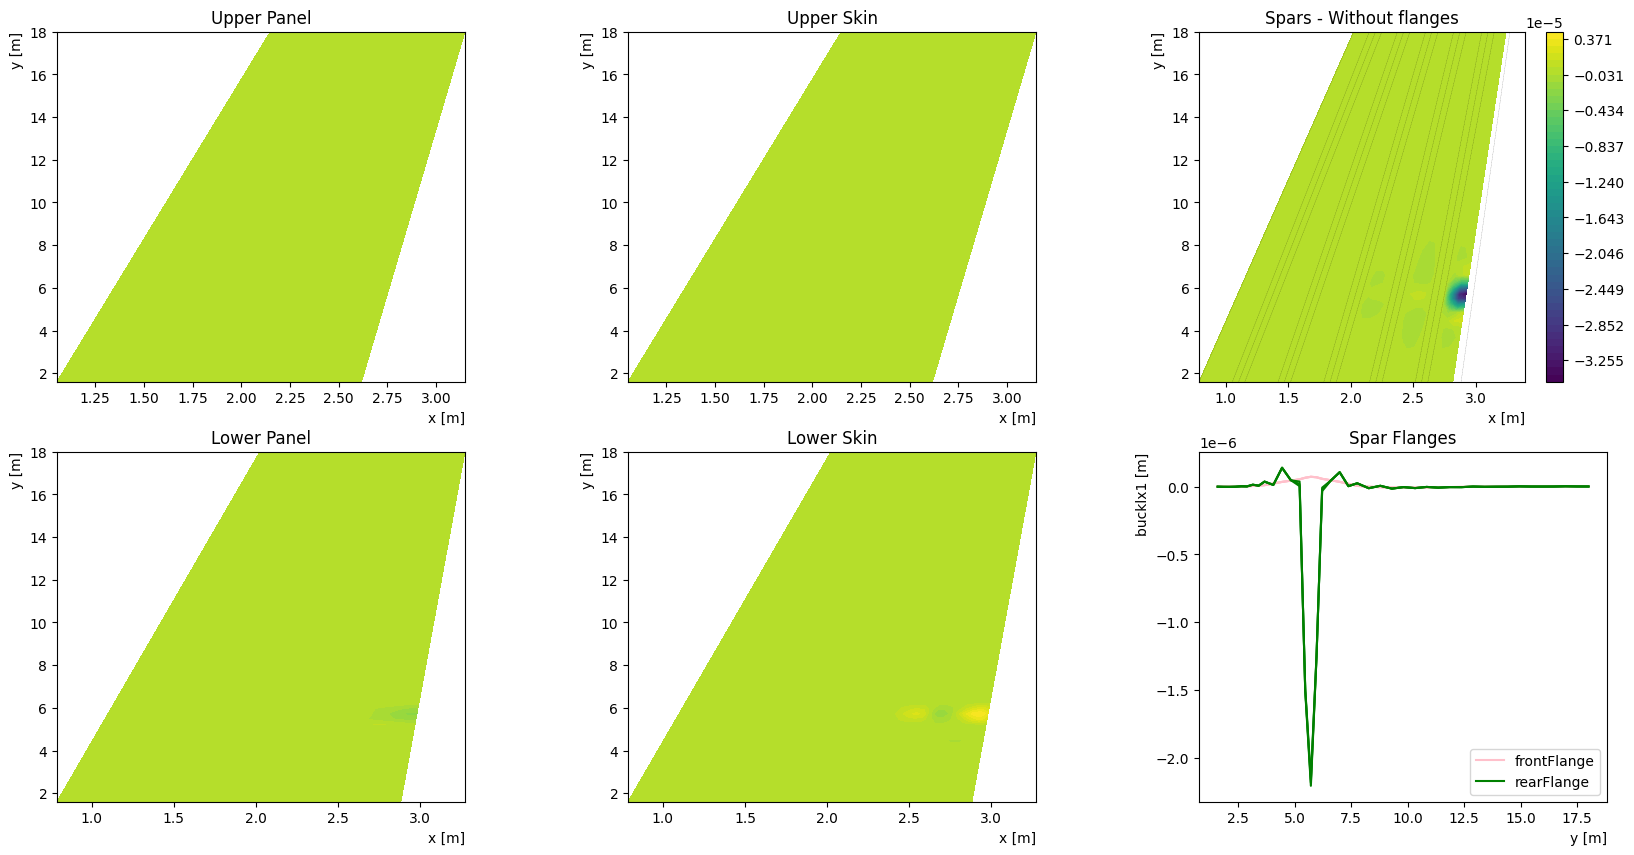

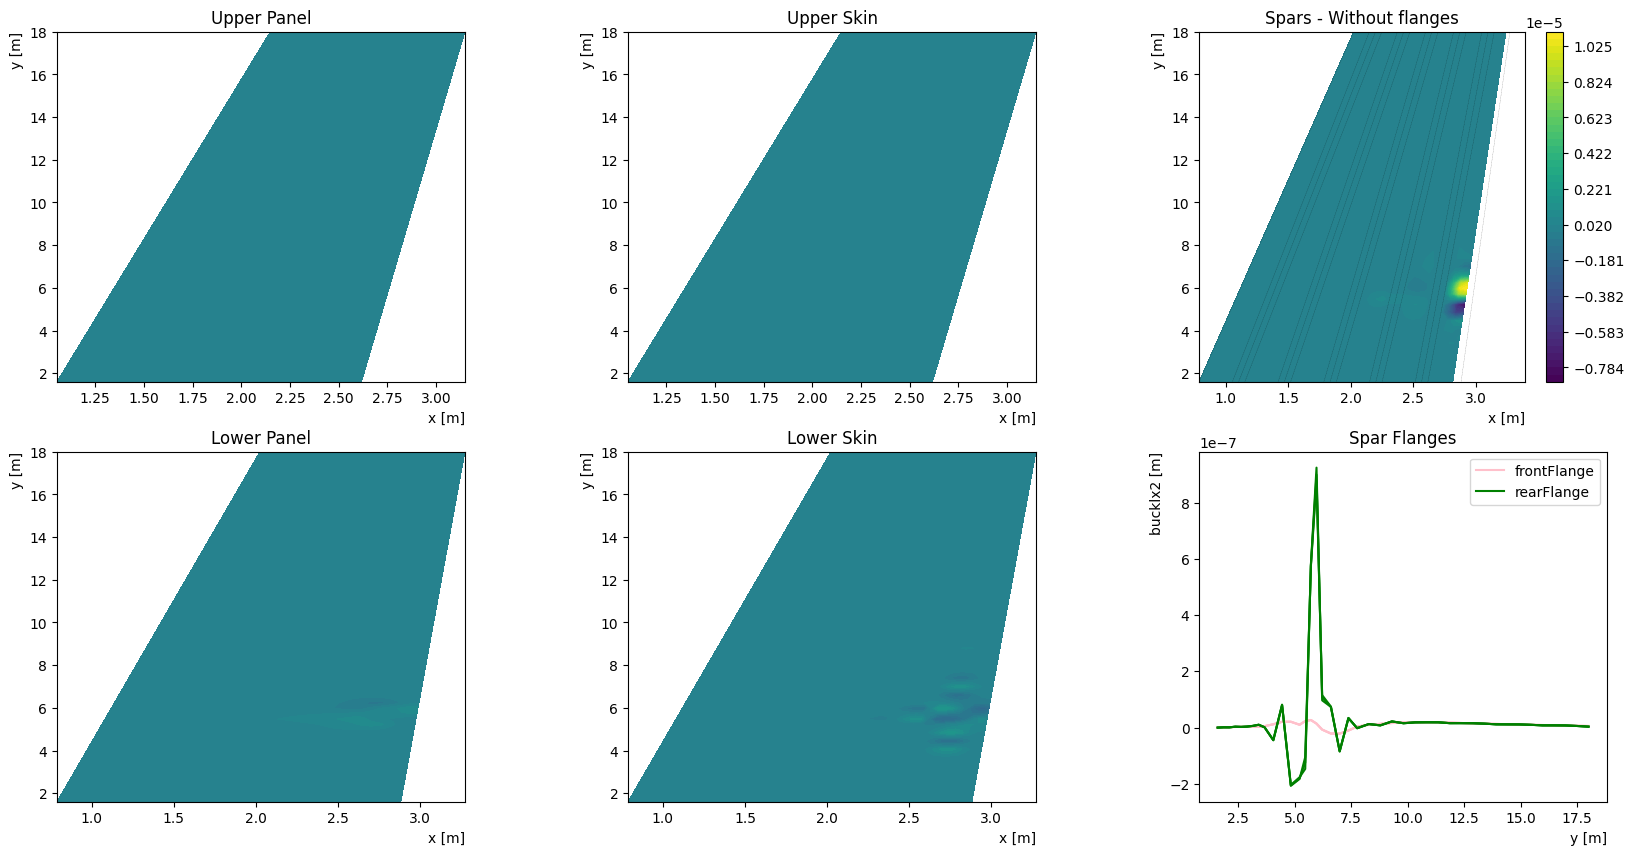

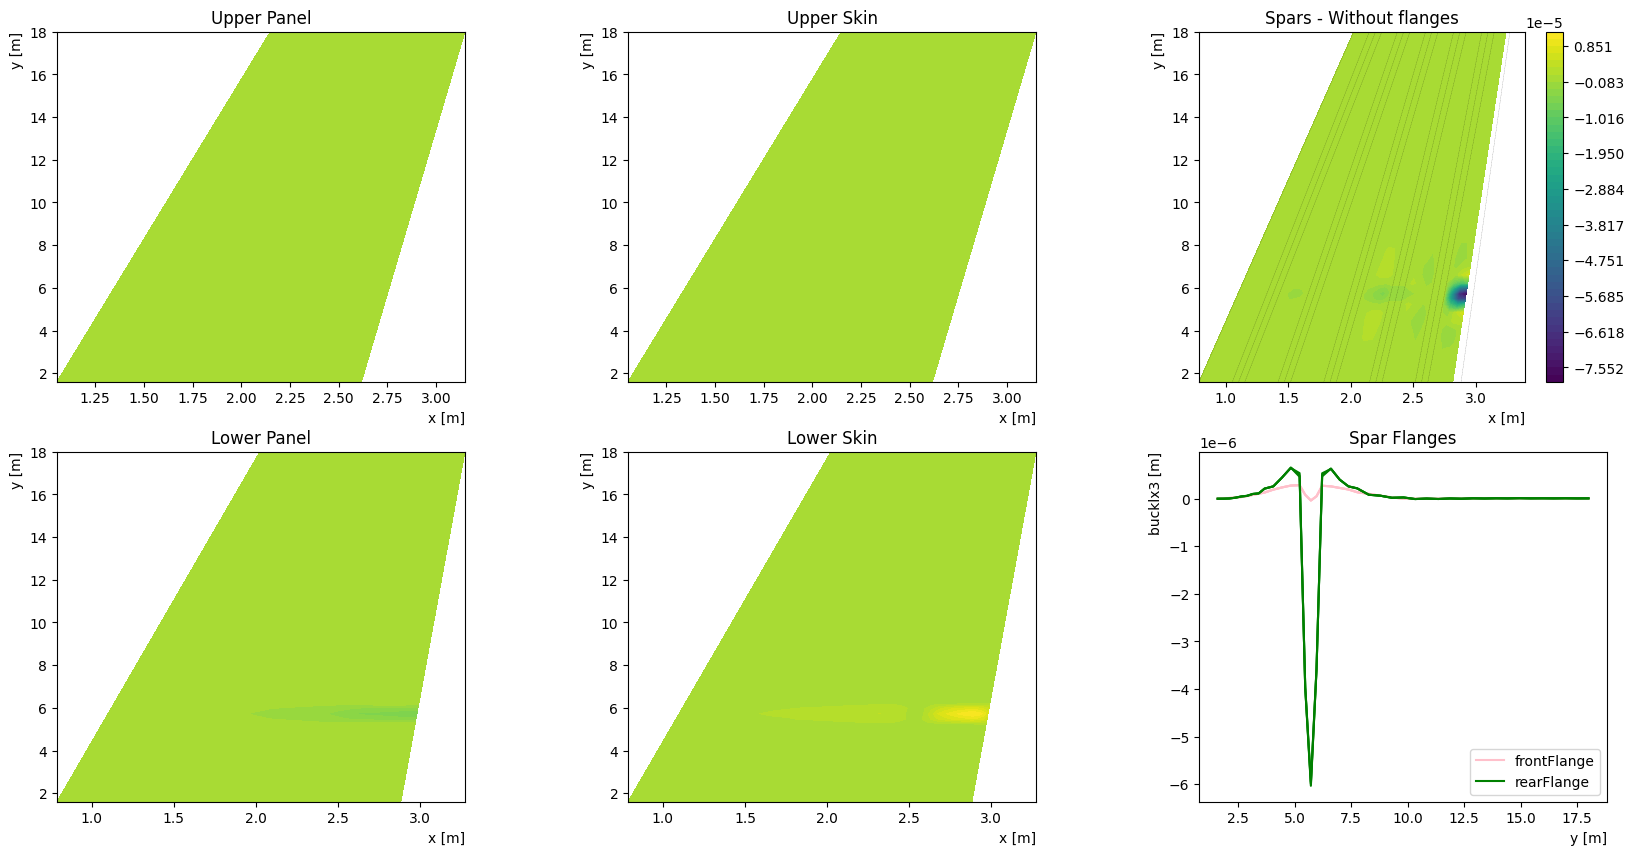

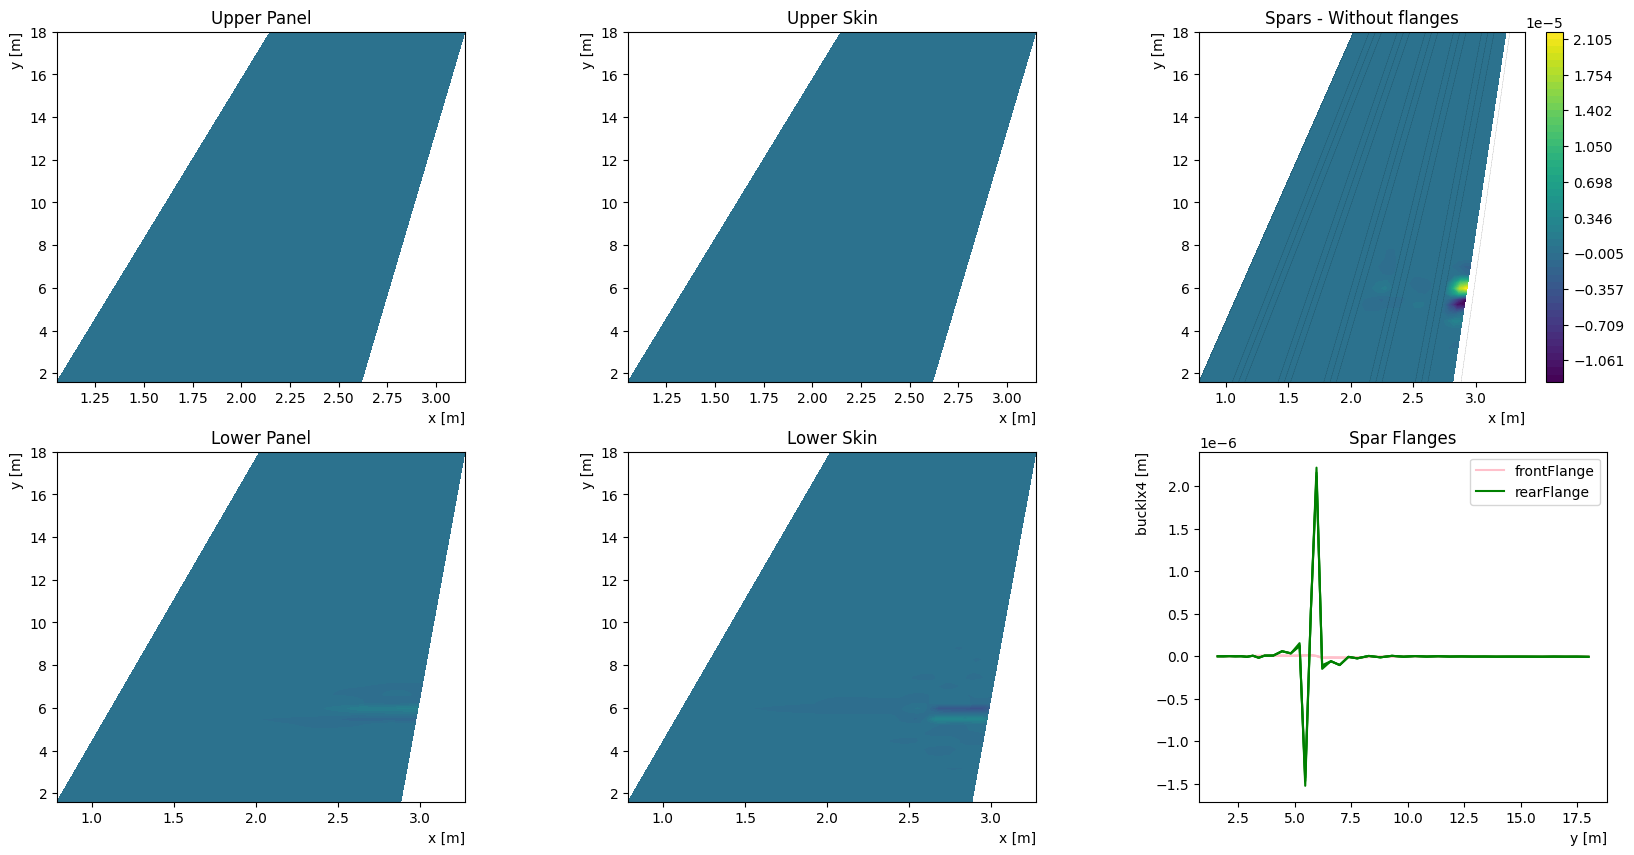

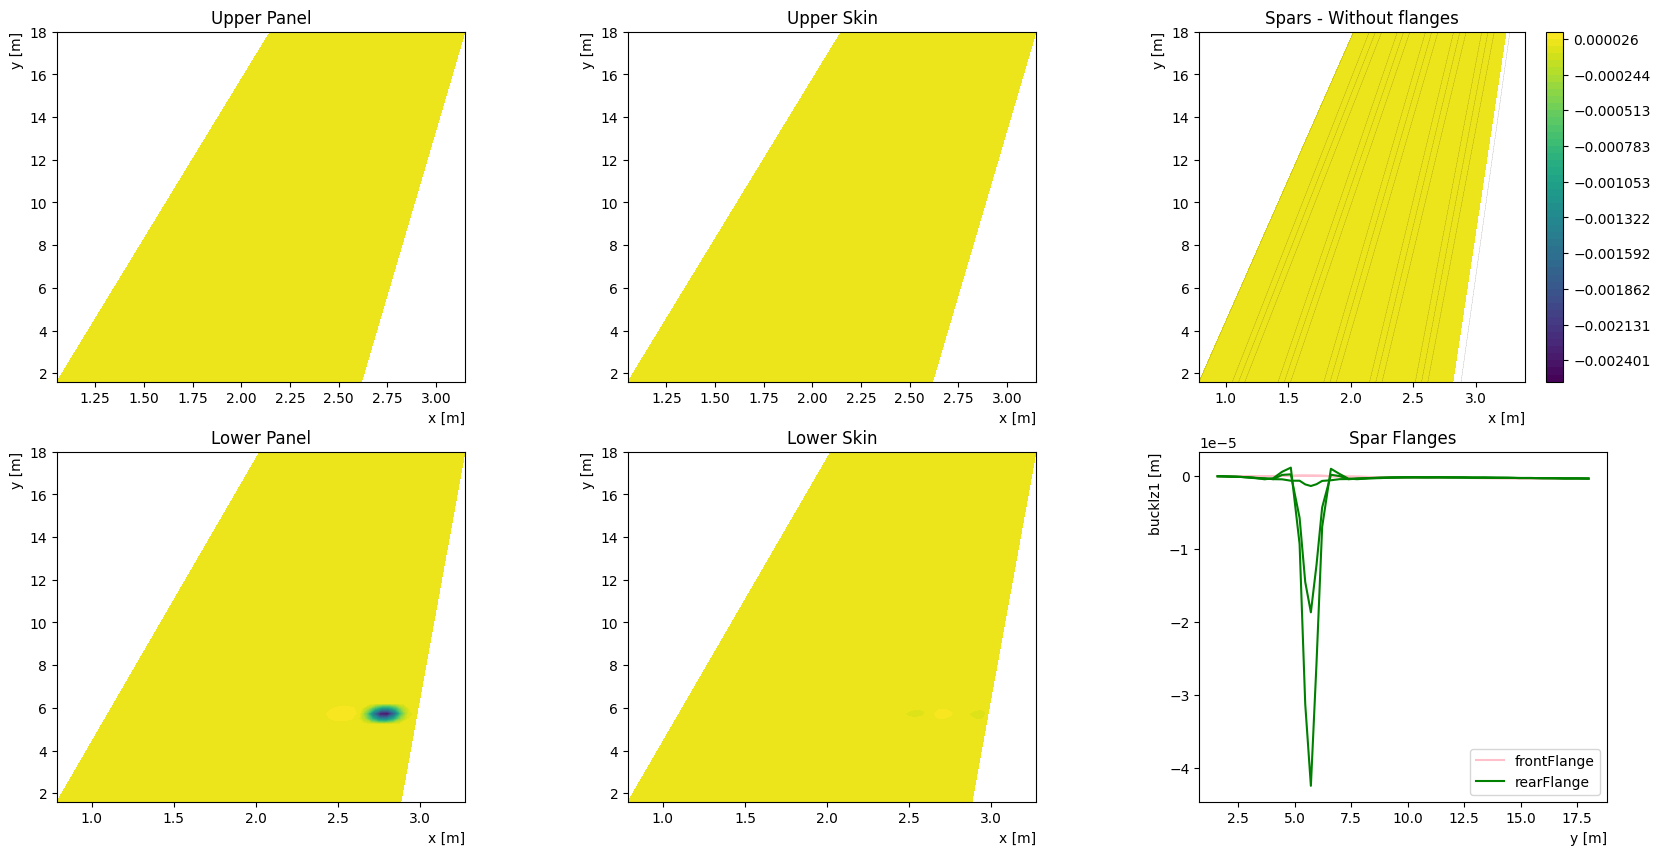

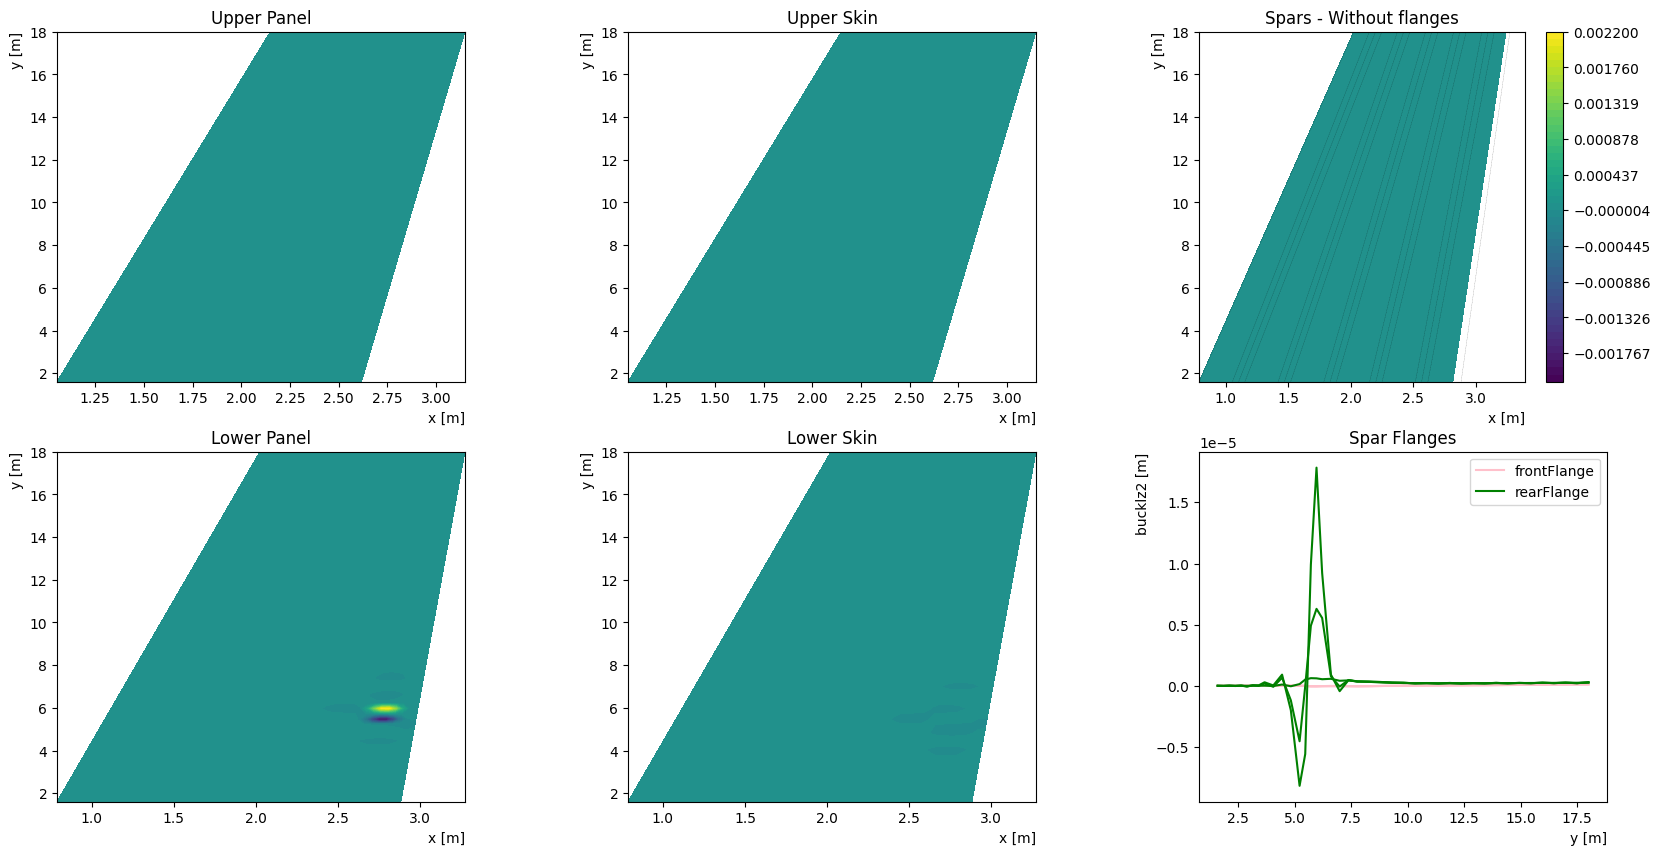

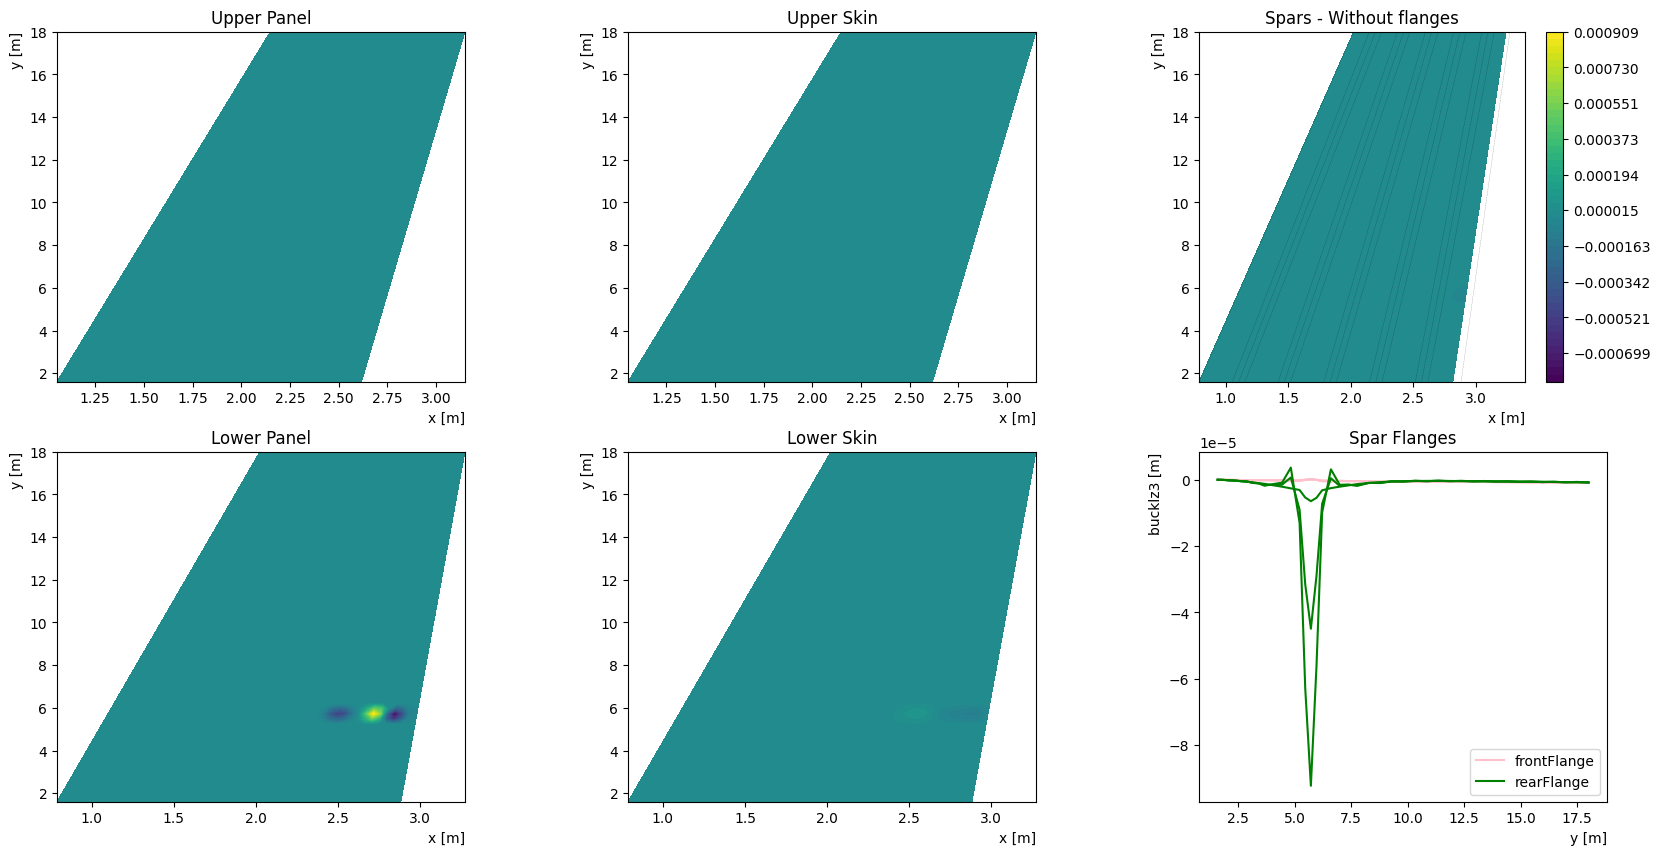

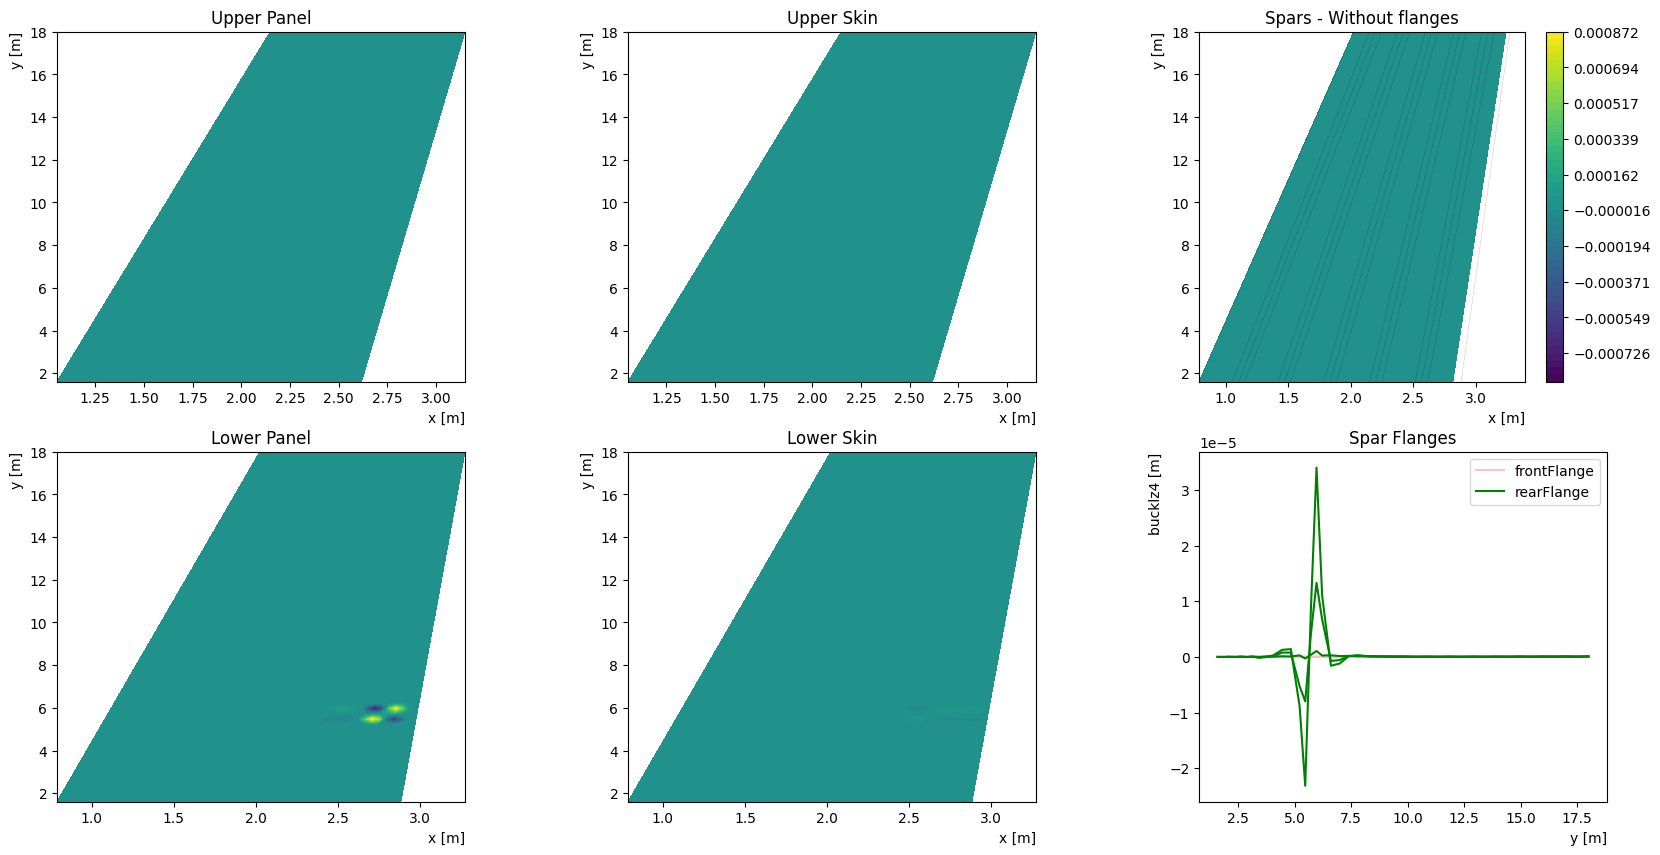

In [13]:
# bl.plot_block(ppd["fi"][0::pf3.DOF], "Fi_x", meshOut, cst.CONSTS, "N")
# bl.plot_block(ppd["fi"][1::pf3.DOF], "Fi_y", meshOut, cst.CONSTS, "N")
# bl.plot_block(ppd["fi"][2::pf3.DOF], "Fi_z", meshOut, cst.CONSTS, "N")
# bl.plot_block(ppd["fi"][3::pf3.DOF], "Mi_x", meshOut, cst.CONSTS, "N")
# bl.plot_block(ppd["fi"][4::pf3.DOF], "Mi_y", meshOut, cst.CONSTS, "N")
# bl.plot_block(ppd["fi"][5::pf3.DOF], "Mi_z", meshOut, cst.CONSTS, "N")
bl.plot_block(ppd["eigvecs"][0::pf3.DOF, 0], "bucklx1", meshOut, cst.CONSTS)
bl.plot_block(ppd["eigvecs"][0::pf3.DOF, 1], "bucklx2", meshOut, cst.CONSTS)
bl.plot_block(ppd["eigvecs"][0::pf3.DOF, 2], "bucklx3", meshOut, cst.CONSTS)
bl.plot_block(ppd["eigvecs"][0::pf3.DOF, 3], "bucklx4", meshOut, cst.CONSTS)
bl.plot_block(ppd["eigvecs"][2::pf3.DOF, 0], "bucklz1", meshOut, cst.CONSTS)
bl.plot_block(ppd["eigvecs"][2::pf3.DOF, 1], "bucklz2", meshOut, cst.CONSTS)
bl.plot_block(ppd["eigvecs"][2::pf3.DOF, 2], "bucklz3", meshOut, cst.CONSTS)
bl.plot_block(ppd["eigvecs"][2::pf3.DOF, 3], "bucklz4", meshOut, cst.CONSTS)
print(ppd["eigvals"])
print(ppd["load_mult"])
print(ppd["omegan"])

# Sizer

In [ ]:

'''A separate cache for eigenvectors'''
v0b = [None]*len(cst.LOAD_C)
v0f = [None]*len(cst.LOAD_C)

@ftl.cache
def _function_optim(optimVars:nt.NDArray[np.float64]):
    '''to be wrapped for particular outputs'''
    sizerVars = {
        'tspar':optimVars[0],
        'tskin':optimVars[1],
        'tpan':optimVars[2],
        'trib':optimVars[3],
        'csp':optimVars[4],
    }

    eleDict = ed.eledict(cst.CONSTS, sizerVars, cst.CODES)
    meshOut = bl.mesh_block(cst.CAD_DATA, sizerVars, eleDict, cst.CONSTS, cst.CODES)
    lfems, lppcs = list(), list()
    jmax_omegans, ldms = list(), list()
    for i, lc in enumerate(cst.LOAD_C):
        femres = bl.fem_linear_block(cst.CONSTS, meshOut, lc)
        ppcres = post_processor_block(femres, meshOut, cst.CODES, sizerVars, cst.CONSTS, v0b[i], v0f[i])
        lfems.append(femres)
        lppcs.append(ppcres)
        jmax_omegans.append(max(np.imag(ppcres["omegan"])))
        ldms.append(ppcres["load_mult"])
        v0b[i] = ppcres["v0b"]
        v0f[i] = ppcres["v0f"]
    
    #constraints
    jmax_omegan = max(jmax_omegans) #there should be no complex part of the natural frequencies, so this has to be kept at 0
    load_mul = max(ldms) #load multiplier for buckling has to be strictly greater than 1
    
    tau_margs, sigma_margs = {}, {}
    def stress_margin(code:str, eletype:str, mat:str): #maximum over all load cases
        return (max(max([ppc["sigma"][eletype][code] for ppc in lppcs]))/cst.CONSTS[f"SIGMAY_{mat}"]/cst.CONSTS["YIELD_MARGIN"], 
                max(max([ppc["tau"][eletype][code] for ppc in lppcs]))/cst.CONSTS[f"TAUY_{mat}"]/cst.CONSTS["YIELD_MARGIN"])
    sigma_margs[cst.CODES["spar"]], tau_margs[cst.CODES["spar"]] = stress_margin(cst.CODES["spar"], "quad", "ALU")
    sigma_margs[cst.CODES["skin"]], tau_margs[cst.CODES["skin"]] = stress_margin(cst.CODES["skin"], "quad", "ALU")
    sigma_margs[cst.CODES["panelPlate"]], tau_margs[cst.CODES["panelPlate"]] = stress_margin(cst.CODES["panelPlate"], "quad", "ALU")
    sigma_margs[cst.CODES["panelRib"]], tau_margs[cst.CODES["panelRib"]] = stress_margin(cst.CODES["panelRib"], "quad", "ALU")
    sigma_margs[cst.CODES["panelFlange"]], tau_margs[cst.CODES["panelFlange"]] = stress_margin(cst.CODES["panelFlange"], "beam", "ALU")
    sigma_margs[cst.CODES["rail"]], tau_margs[cst.CODES["rail"]] = stress_margin(cst.CODES["rail"], "beam", "STEEL")
    
    #objective
    totWgMass = meshOut["M"].diagonal()[2::pf3.DOF].sum()            
    
    return totWgMass, jmax_omegan, load_mul, sigma_margs, tau_margs

def mass_objective(optimVars:nt.NDArray[np.float64]):
    totWgMass, _, _, _, _ = _function_optim(tuple(optimVars))
    return totWgMass

def buckling_constraint(optimVars:nt.NDArray[np.float64]):
    _, _, load_mul, _, _ = _function_optim(tuple(optimVars))
    return load_mul

_buckling_constraint = opt.NonlinearConstraint(buckling_constraint, 0, 1)

def flutter_constraint(optimVars:nt.NDArray[np.float64]):
    _, jmax_omegan, _, _, _ = _function_optim(tuple(optimVars))
    return jmax_omegan

_flutter_constraint = opt.NonlinearConstraint(flutter_constraint, -.001, .001) #TODO determine tolerance

# Create a constraint for a specific sigma_margs index
def make_sigma_constraint(idx):
    def constraint(optimVars):
        _, _, _, sigma_margs, _ = _function_optim(optimVars)
        return np.array([sigma_margs[idx]])  # single value in array
    return opt.NonlinearConstraint(constraint, -1, 1)

# Create a constraint for a specific tau_margs index
def make_tau_constraint(idx):
    def constraint(optimVars):
        _, _, _, _, tau_margs = _function_optim(optimVars)
        return np.array([tau_margs[idx]])  # single value in array
    return opt.NonlinearConstraint(constraint, -1, 1)

# Build the lists of constraints
sigma_constraints = [make_sigma_constraint(i) for i in range(6)]
tau_constraints   = [make_tau_constraint(i) for i in range(6)]

_len_opt_Vars = len(cst.INITIAL.keys())
_ts_only_mat = np.eye(_len_opt_Vars)
_ts_only_mat[-1, -1] = 0 #removing the cs
_trange_constraint = opt.LinearConstraint(_ts_only_mat, 0, .01) #everything but cspacing

_ss_only_mat = np.zeros((_len_opt_Vars, _len_opt_Vars))
_ss_only_mat[-1, -1] = 1
_srange_constraint = opt.LinearConstraint(_ss_only_mat, 0, 1)

#an assembly of all the constraints needed
constraints = [_srange_constraint, _trange_constraint, _buckling_constraint, _flutter_constraint]+sigma_constraints+tau_constraints

# Counter and logging interval
class Logger:
    def __init__(self, every_n=10):
        self.count = 0
        self.every_n = every_n

    def __call__(self, xk):
        self.count += 1
        if self.count % self.every_n == 0:
            print(f"Iter {self.count}: x = {xk}, f = {mass_objective(xk)}, time = {datetime.datetime.now()}")


#this block is directly dependent on the cst module
def sizer_block():
    return opt.minimize(mass_objective, [cst.INITIAL[k] for k in ['tspar', 'tskin', 'tpan', 'trib', 'csp']], constraints=constraints,
                        method="COBYLA", callback=Logger())

## Main optim function testing

In [ ]:
optimVars=tuple(cst.INITIAL[k] for k in ['tspar', 'tskin', 'tpan', 'trib', 'csp'])
loadm = buckling_constraint(optimVars)
print(f"load multiplier: {loadm}")
jmax_omegan = flutter_constraint(optimVars)
print(f"complex part of natural freq: {loadm}")

C:\Users\marri\AppData\Local\Temp\ipykernel_7332\3008388835.py:189: ComplexWarning: Casting complex values to real discards the imaginary part
  eigvectsO[bu] = eigvectsOu[:, 0]


ValueError: Input must be 1- or 2-d.